In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import pickle
import MDAnalysis as mda
import mdtraj as md
import numpy as np
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler
from statsmodels.stats.weightstats import DescrStatsW
import warnings
warnings.filterwarnings('ignore') # make the notebook nicer

##################
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large' }

plt.rcParams.update(params)

plt.rc('axes', prop_cycle = cycler('color', ['#377eb8', '#ff7f00', '#4daf4a',
                  '#e41a1c', '#984ea3', '#f781bf', '#a65628', 
                  '#999999', '#dede00']))
cm = ['#377eb8', '#ff7f00', '#4daf4a', '#e41a1c', '#984ea3',
                  '#f781bf', '#a65628', 
                  '#999999', '#dede00']

sys.path.append("/projects/prism/people/mhz916/software/BLOCKING")
from main import BlockAnalysis

/maps/projects/prism/people/mhz916/software/envs/calvados/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def calculate_concentration(n_chains,V,MW,NA=6.022e23,mass=False):
    n = n_chains/NA
    concentration = n/V
    if mass: concentration = (n*MW)/V
    return concentration

f_lin = lambda x,a,b: a*x+b
f_exp =  lambda x,a,b: a*b**x

In [4]:
residues = pd.read_csv("./residues.csv").set_index('one')
df_proteins = pd.read_pickle("proteins.pkl")
L=15
df_proteins["conv"] = df_proteins.apply(lambda x: 1e5/6.022/x["N_res"]/L/L, axis=1)
df_proteins["MW"] = df_proteins.apply(lambda x: np.sum(residues.loc[x["fasta"],'MW']),axis=1)

def phi_conversion(mw,sequence):
    if 'J' in sequence: # peg
        return mw*0.001/1120
    else: # protein
        return mw*0.001/1310

df_proteins["conv_phi"] = df_proteins.apply(lambda x: phi_conversion(x['MW'],x['fasta']),axis=1)
df_proteins


pH  ionic                                              fasta  \
seq_name                                                                    
PEG400      7.0   0.11                        [J, J, J, J, J, J, J, J, J]   
PEG2050     7.0   0.11  [J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, ...   
PEG2000     7.0   0.11  [J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, ...   
PEG4600     7.0   0.11  [J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, ...   
PEG6000     7.0   0.11  [J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, ...   
PEG8000     7.4   0.25  [J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, ...   
PEG12000    7.0   0.11  [J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, ...   
PEG20000    7.0   0.11  [J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, ...   
PEG35000    7.0   0.11  [J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, ...   
ACTR        7.0   0.11  [G, T, Q, N, R, P, L, L, R, N, S, L, D, D, L, ...   
aSyn        7.4   0.25  [M, D, V, F, M, K, G, L, S, K, A, K, E, G, V, ...   
aSynM5DP5A  7.4   0.25  [M, D, V, F, M, K, G, L, S, K, A, K, E, G, V, ...   
A1          7.0   0.15  [G, S, M, A, S, A, S, S, S, Q, R, G, R, S, G, ...   
AroM        7.0   0.15  [G, S, M, A, S, A, S, S, S, Q, R, G, R, S, G, ...   
AroMM       7.0   0.15  [G, S, M, A, S, A, S, S, S, Q, R, G, R, S, G, ...   
ProTaC      7.0   0.11  [C, E, E, G, G, E, E, E, E, E, E, E, E, G, D, ...   
ProTaN      7.0   0.11  [C, D, A, A, V, D, T, S, S, E, I, T, T, K, D, ...   
IN          7.0   0.11  [C, A, Q, E, E, H, E, K, A, H, S, N, F, R, A, ...   

            temp  N_res      conv        MW  conv_phi  
seq_name                                               
PEG400       295      9  8.200385    396.45  0.000354  
PEG2050      295     47  1.570286   2070.35  0.001849  
PEG2000      295     45  1.640077   1982.25  0.001770  
PEG4600      295    105  0.702890   4625.25  0.004130  
PEG6000      295    135  0.546692   5946.75  0.005310  
PEG8000      295    181  0.407754   7973.05  0.007119  
PEG12000     295    272  0.271336  11981.60  0.010698  
PEG20000     295    454  0.162563  19998.70  0.017856  
PEG35000     295    794  0.092951  34975.70  0.031228  
ACTR         295     71  1.039485   7683.40  0.005865  
aSyn         277    140  0.527168  14441.85  0.011024  
aSynM5DP5A   277    140  0.527168  14221.75  0.010856  
A1           293    137  0.538711  13080.36  0.009985  
AroM         298    137  0.538711  12687.76  0.009685  
AroMM        298    137  0.538711  12219.06  0.009328  
ProTaC       295     54  1.366731   5979.54  0.004565  
ProTaN       295     55  1.341881   5948.91  0.004541  
IN           295     49  1.506193   5352.95  0.004086

## Loading Data

### Single Chain PEG

In [ ]:
# Loading processesd single chain PEG (scp) simulation data
rg_values_scp = pd.read_pickle("./data/single-chain-PEG__rg-data.pkl")

with open(F"./data/single-chain-PEG__block-analysis.pkl", 'rb') as pf:
    block_analysis_scp = pickle.load(pf)

with open(F"./data/single-chain-PEG__metrics.pkl", 'rb') as pf:
    metrics_scp = pickle.load(pf)

### Protein Crowding

In [ ]:
# Loading data for the proteins ACTR & IN simulated with increasing concentrations of PEG400 & PEG8000
with open("./data/protein-crowding__data__ACTR.pkl",'rb') as pf:
    ACTR = pickle.load(pf)

with open("./data/protein-crowding__data__IN.pkl",'rb') as pf:
    IN   = pickle.load(pf)

### PS Crowding

In [5]:
percentages_to_numbers = {"PEG8000":{0:0,2.5:64,5:127,7.5:191,10:254,12.5:318,15:381,20:508},
                          "PEG400":{0:0,2.5:1287,5:2554,7.5:3841,10:5108},
                          "PEG20000":{0:0,2.5:26,5:51,7.5:76,10:101}
                         }

peg_percentages = {('A1','PEG8000'):[0,2.5,5,7.5,10],
                   ("A1","PEG400"):[0,2.5,5,7.5,10],
                   ("AroM", "PEG8000"):[0,2.5,5,7.5,10],
                   ("AroMM","PEG8000"):[0,2.5,5,7.5,10],
                   #("Ddx4","PEG8000"):[0.7,1.2,2.5,5,7.5,10],
                   ("aSyn","PEG400"):[0,2.5,5,7.5,10],
                   ("aSyn2745","PEG400"):[0,2.5,5,7.5,10]
                   }

In [ ]:
### Data A1 & aSyn systems ###
data = pd.read_pickle("./data/peg-llps__data__A1-aSyn.pkl")
with open("./data/peg-llps__block-analysis__A1-aSyn.pkl",'rb') as pf:
    block_analysis = pickle.load(pf)

# Data aSyn variant
data_var = pd.read_pickle("./data/peg-llps__data__aSynVar.pkl")
with open("./data/peg-llps__block-analysis__aSynVar.pkl",'rb') as pf:
    block_analysis_var = pickle.load(pf)

### Data Ddx4n1 ###
# Ddx4 simulation data
data_ddx4 = pd.read_pickle("./data/peg-llps__data__Ddx4.pkl")
# Csat Data with PEG3000 from fig. 1d - second panel Stender et al.
expData = pd.read_csv("./data/peg-llps__experimental_peg_data__Ddx4.csv",sep=';').set_index('PEG3000 concentration (%w/v)')
# Csat Data from fig. 1d - first panel Stender et al.
df_csat_ddx4 = pd.read_csv("./data/peg-llps__experimental_csat_data__Ddx4.csv")
#calculate weighted standard deviation
wSD_ddx4 = DescrStatsW(df_csat_ddx4['Csat_ave'], weights=df_csat_ddx4['Csat_sd'], ddof=1).std

## Figures

### Figure 1

#### Panel A

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

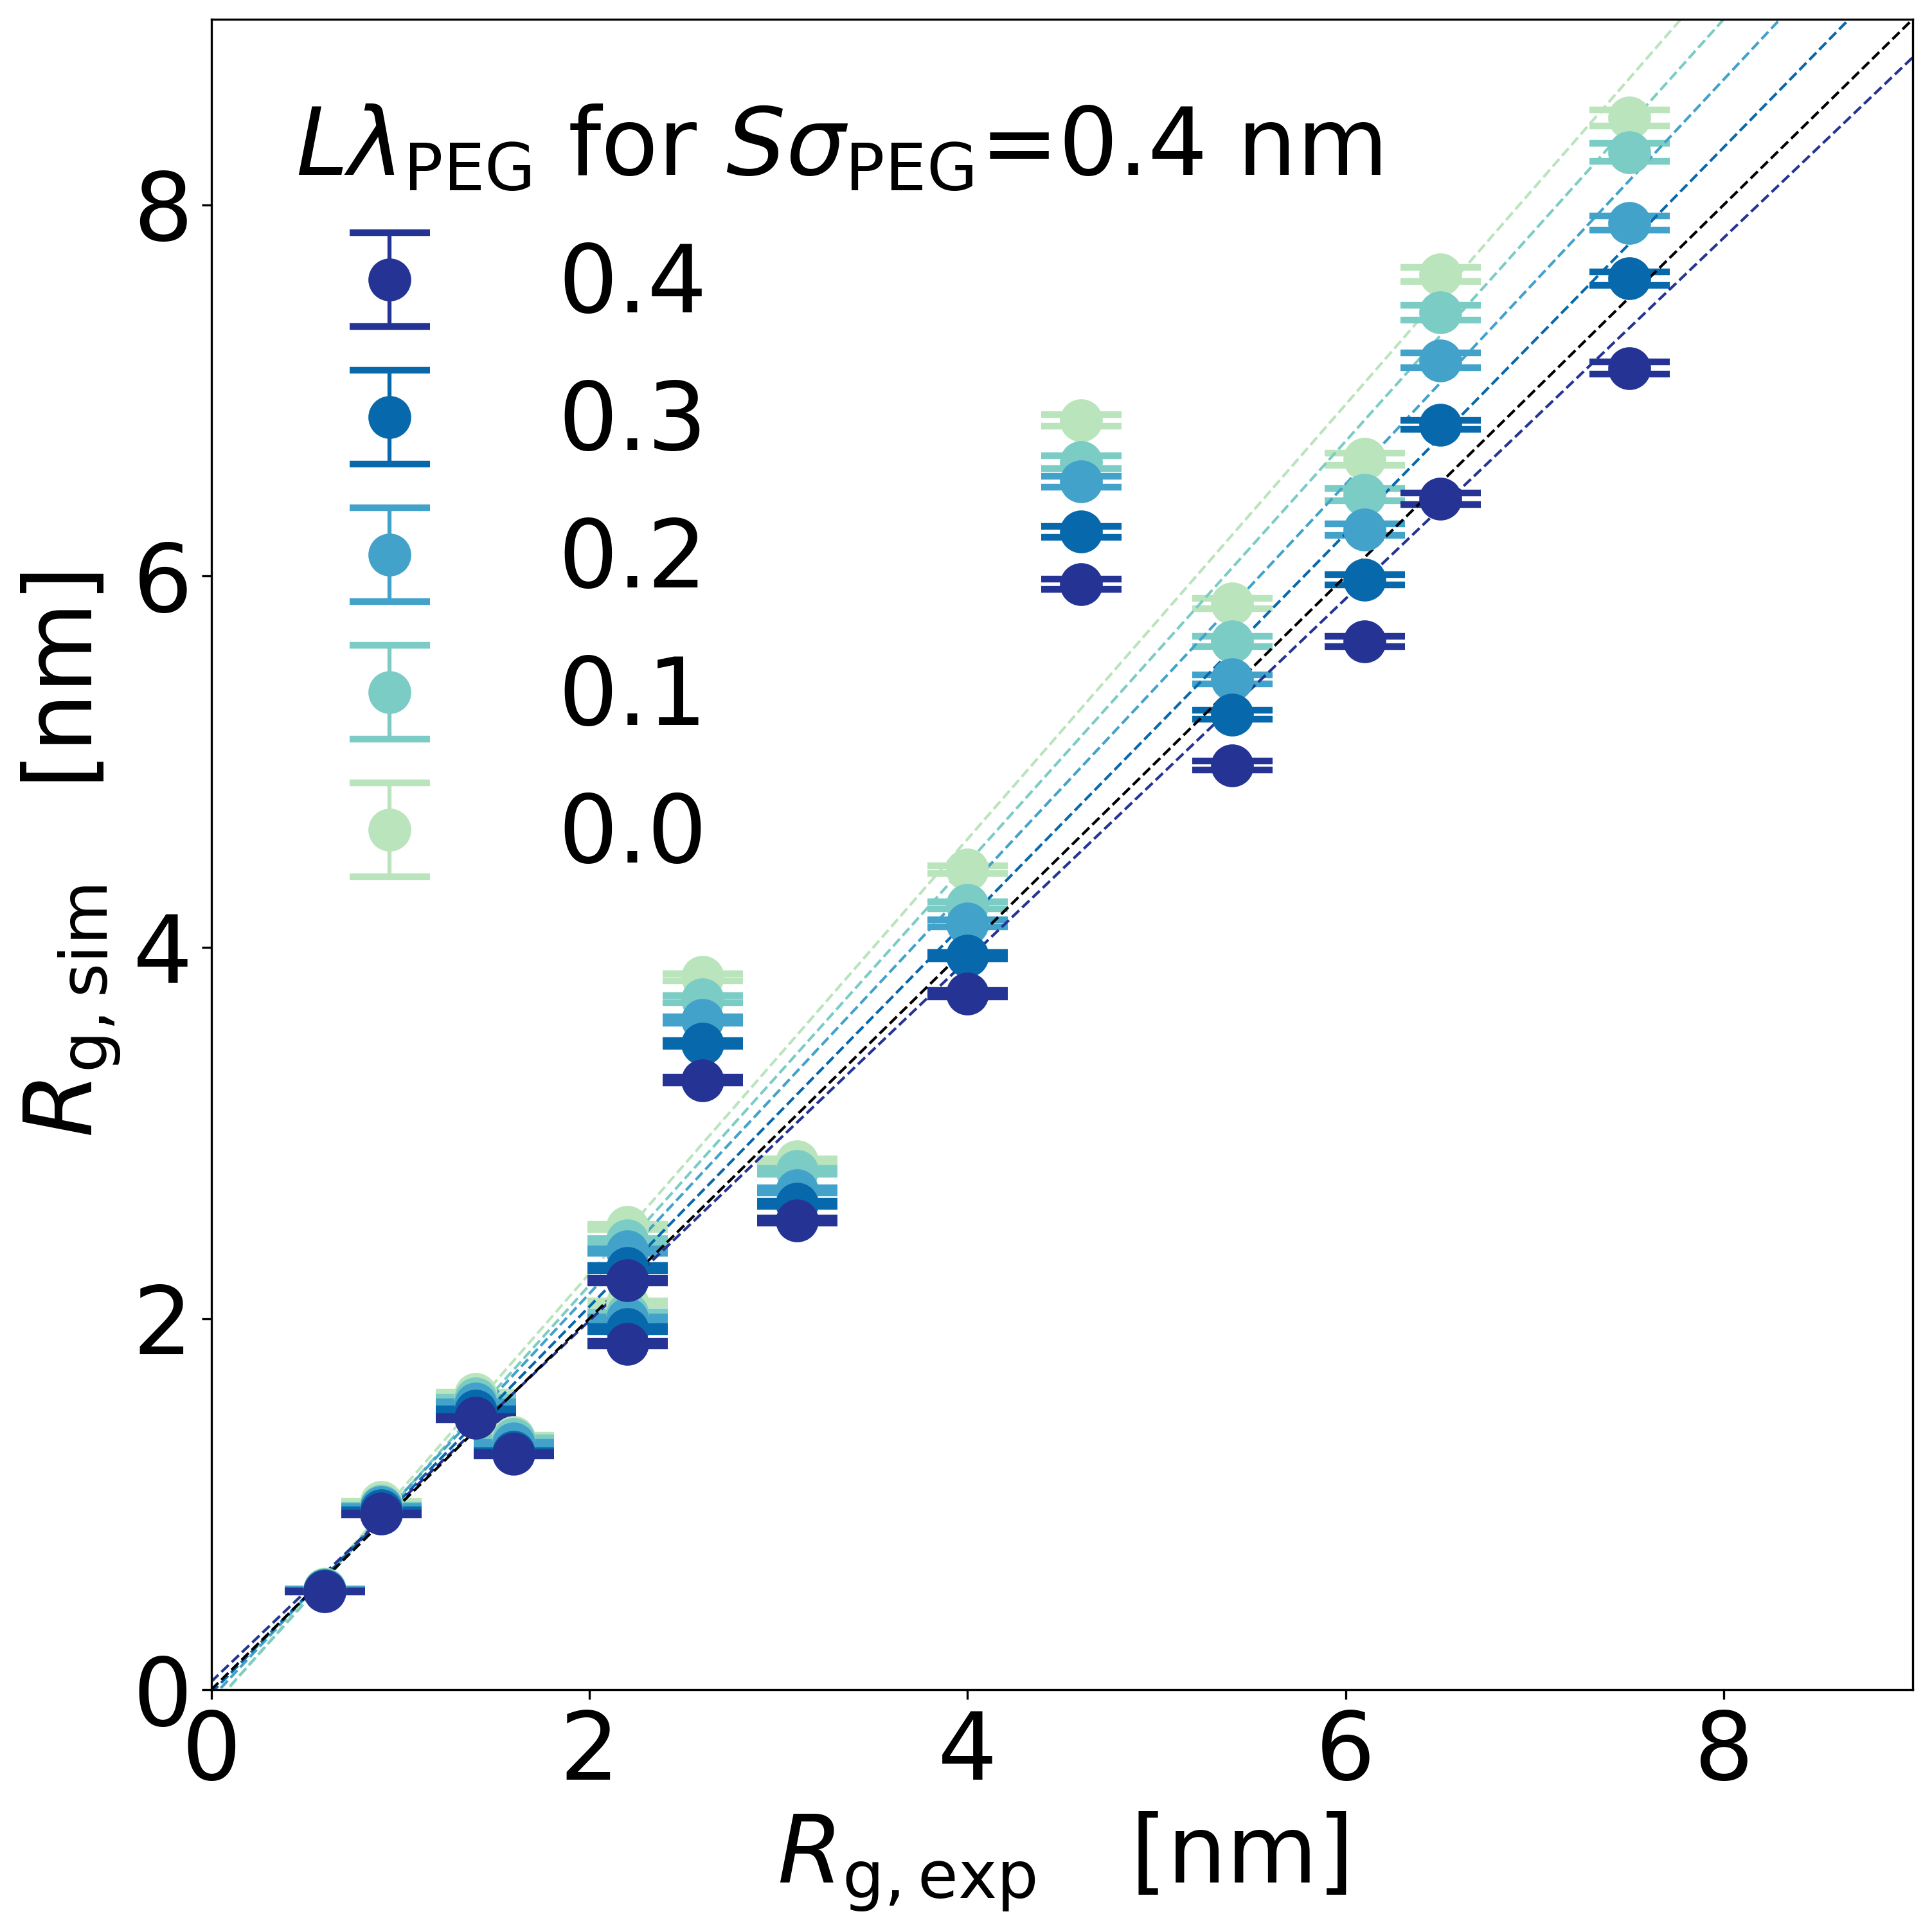

In [ ]:
colours = ['#bae4bc','#7bccc4','#43a2ca','#0868ac','#253494']

fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(10,10),dpi=300)

for i, l in enumerate([0.0,0.1,0.2,0.3,0.4]):
    ax.errorbar(x=rg_values_scp.loc[:,l,0.4]['expRg'].to_numpy(),
                y=rg_values_scp.loc[:,l,0.4]['simRg'].to_numpy(),
                yerr=rg_values_scp.loc[:,l,0.4]['simRgSEM'].to_numpy(),
                marker='o', barsabove=False, ls='', label=F"{l}", markersize=15, capsize=15,capthick=2.5,color=colours[i])
    # Fit on average
    popt, _ = curve_fit(f_lin, rg_values_scp.loc[:,l,0.4]['expRg'].to_numpy(), rg_values_scp.loc[:,l,0.4]['simRg'].to_numpy(), [1,-4])
    xfit = np.linspace(0,10)
    ax.plot(xfit, f_lin(xfit,*popt),ls='--',lw=1.,color=colours[i])

ax.set_xlim(0,9)
ax.set_ylim(0,9)
ax.tick_params(axis="x", labelsize=35) 
ax.tick_params(axis="y", labelsize=35) 
ax.set_xlabel(r"$R_\mathrm{g,exp}$   [nm]", fontsize=35)
ax.set_ylabel(r"$R_\mathrm{g,sim}$   [nm]", fontsize=35)
ax.plot(xfit, f_lin(xfit,1,0),ls='--',lw=1.,color='k')

ax.legend(frameon=False, title="$\lambda_\mathrm{PEG}$          $\sigma_\mathrm{PEG}$=0.4 nm", loc='upper left',alignment='left', fontsize=35, title_fontsize=35,reverse=True)
fig.tight_layout()
fig.savefig("./figures/PEG-single-chain__rg-v-rg.pdf")

#### Panel B

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

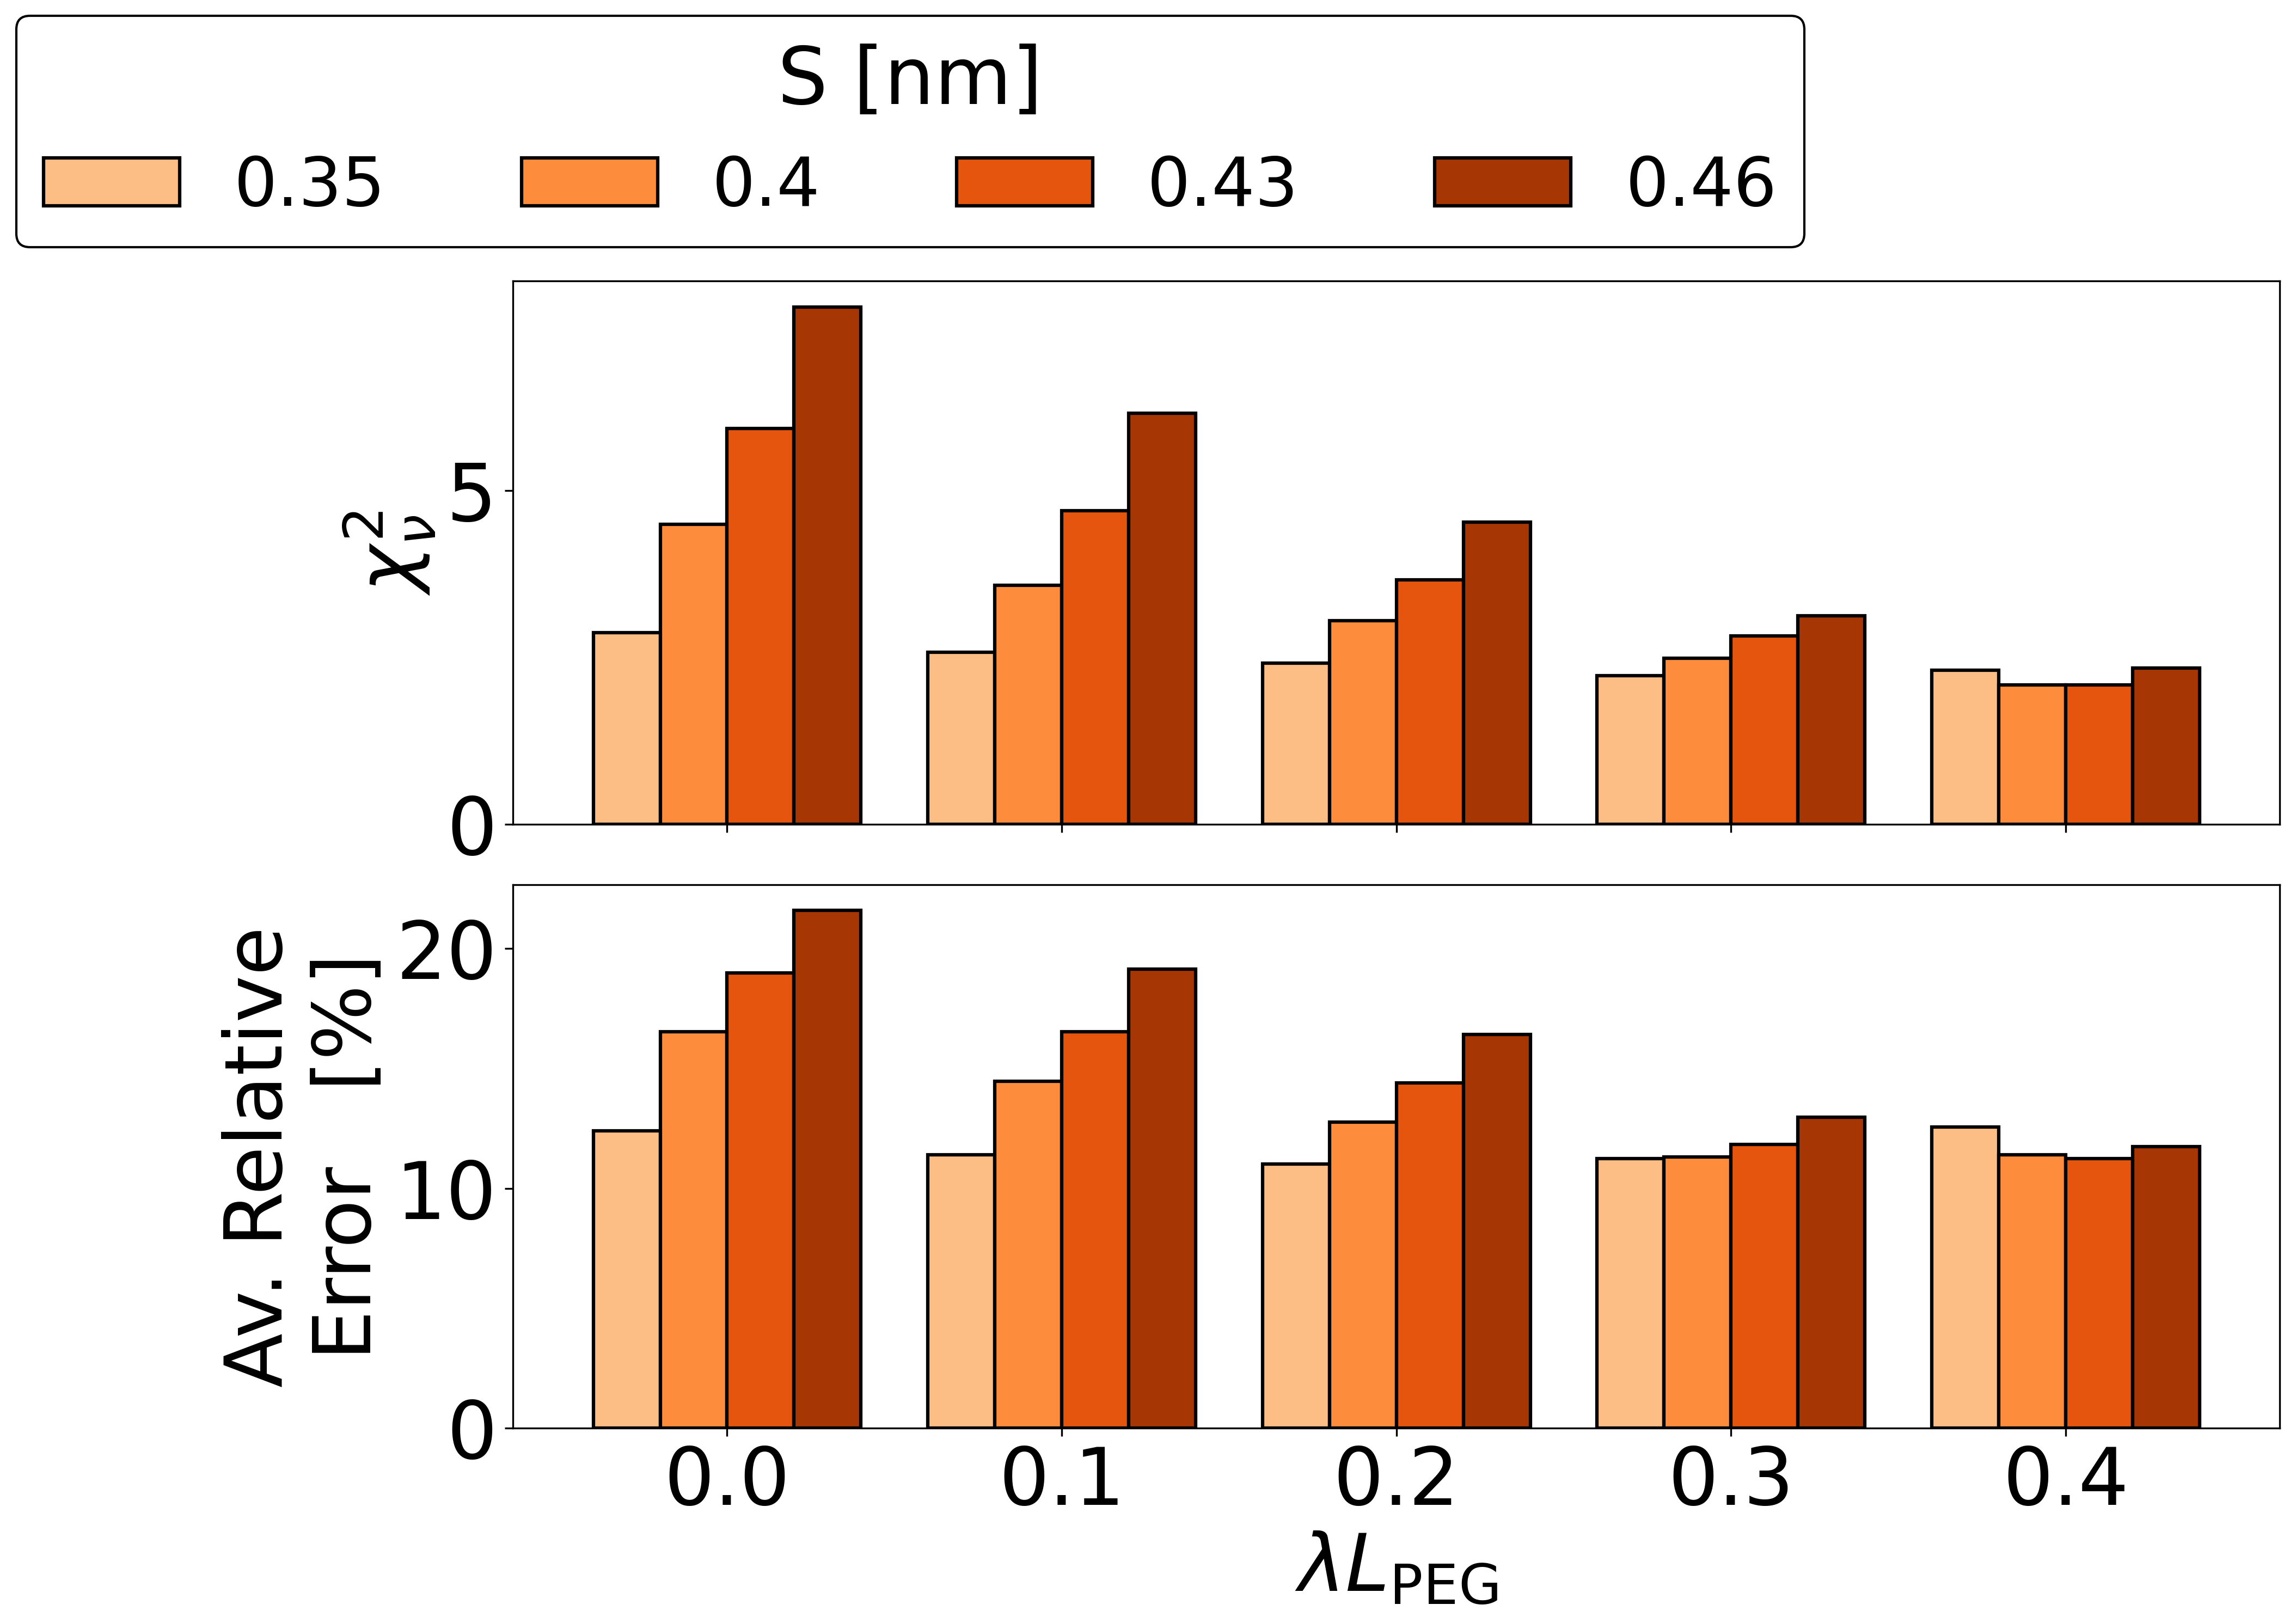

In [ ]:
colors = ['#fdbe85','#fd8d3c','#e6550d','#a63603']

fig, axs = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(14,10),dpi=300)
# Define Data
ls = ['0.0','0.1','0.2','0.3','0.4']
x_axis = np.arange(len(ls))
# Multi bar Chart
data = metrics_scp['chi2Red']
axs[0].bar(x_axis-0.3, data.loc[0.35],
           width=0.2, label = '0.35', color=colors[0],lw=1.5,edgecolor='black')
axs[0].bar(x_axis -0.1, data.loc[0.4],
           width=0.2, label = '0.4', color=colors[1],lw=1.5,edgecolor='black')
axs[0].bar(x_axis +0.1, data.loc[0.43],
           width=0.2, label = '0.43', color=colors[2],lw=1.5,edgecolor='black')
axs[0].bar(x_axis +0.3, data.loc[0.46],
           width=0.2, label = '0.46', color=colors[3],lw=1.5,edgecolor='black')

# Xticks
axs[0].set_xticks(ticks=x_axis) 
axs[0].set_xticklabels(ls, fontsize=35)
axs[0].tick_params(axis="y", labelsize=35) 
# axs[0].set_xlabel(r"$\lambda$", fontsize=35)
axs[0].set_ylabel(r"$\chi_{\nu}^{2}$", fontsize=35)



####
data = metrics_scp['aveRelError']
axs[1].bar(x_axis -0.3, data.loc[0.35],
           width=0.2, label = '0.35', color=colors[0],lw=1.5,edgecolor='black')
axs[1].bar(x_axis -0.1, data.loc[0.4],
           width=0.2, label = '0.4', color=colors[1],lw=1.5,edgecolor='black')
axs[1].bar(x_axis +0.1, data.loc[0.43],
           width=0.2, label = '0.43', color=colors[2],lw=1.5,edgecolor='black')
axs[1].bar(x_axis +0.3, data.loc[0.46],
           width=0.2, label = '0.46', color=colors[3],lw=1.5,edgecolor='black')

# Xticks
axs[1].set_xticks(ticks=x_axis) 
axs[1].set_xticklabels(ls, fontsize=35)
axs[1].tick_params(axis="y", labelsize=35) 
axs[1].set_xlabel(r"$\lambda L_\mathrm{PEG}$", fontsize=35)
axs[1].set_ylabel("Av. Relative\nError   [%]", fontsize=35)

# Add legend
axs[0].legend(title="S [nm]", fontsize=30,title_fontsize=35,frameon=True,ncol=4,edgecolor='k',framealpha=1,bbox_to_anchor=(.75, 1.55));
fig.tight_layout(pad=1)
fig.savefig("./figures/PEG-single-chain__barplots-parameter-scan.pdf",facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight');

### Figure 2

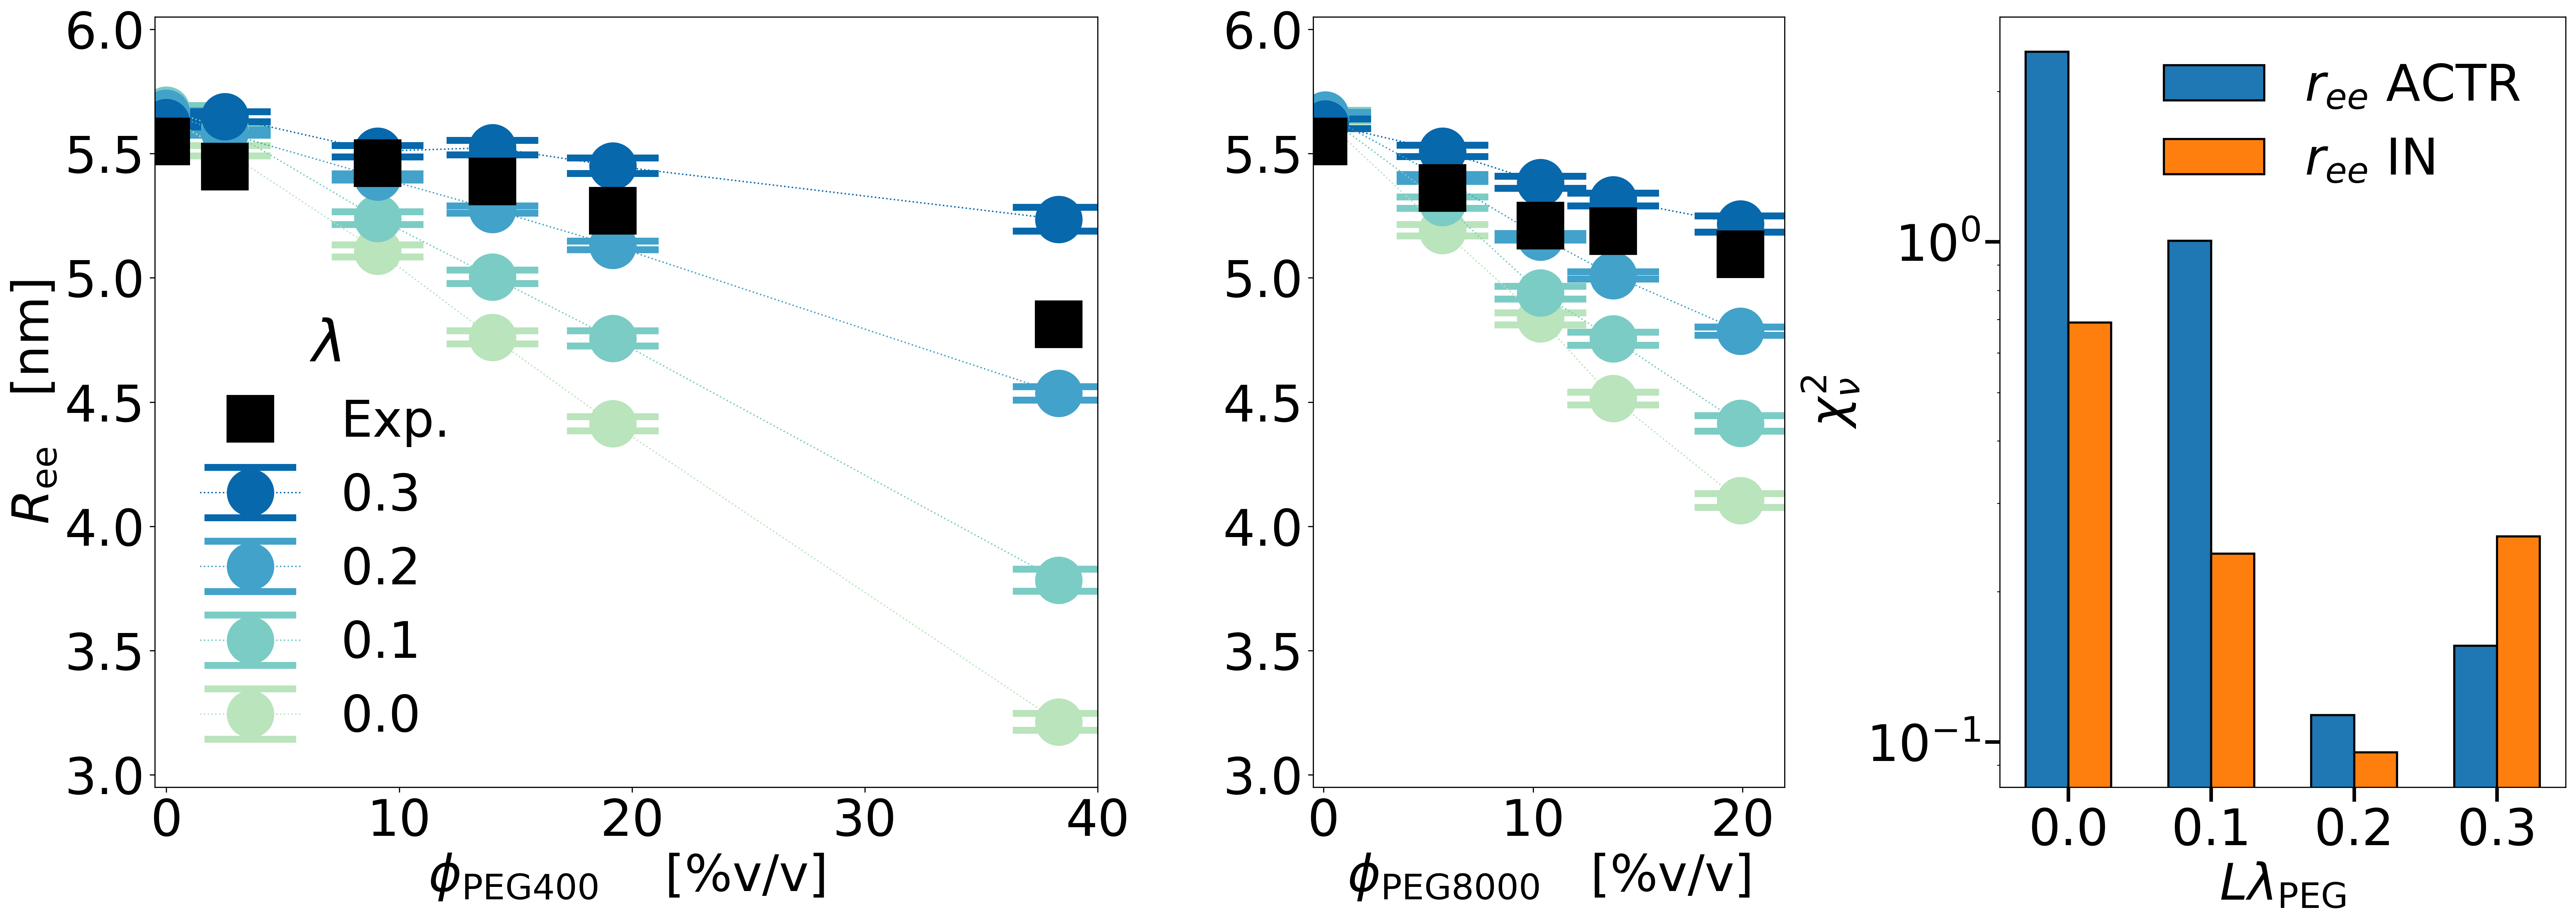

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=3,gridspec_kw={'width_ratios':[2, 1, 1.2]},figsize=(25,9),dpi=300)  #,sharey=True

subs = []
nrows = 3
ncols = 2

# size_exp = 280
col_exp  = 'k'
marker_offset=1.6
marks = {'PEG400':'o', 'PEG8000':'o'}
colors = ['#bae4bc','#7bccc4','#43a2ca','#0868ac']

for l, col in zip([0.0, 0.1, 0.2, 0.3],colors):
    for i, peg in enumerate(["PEG400","PEG8000"]):
        axs[i].errorbar(x=ACTR[(l,peg)]['vv'],
                        y=ACTR[(l,peg)]['simRee'],
                        yerr=ACTR[(l,peg)]['simReeSEM'],
                        marker=marks[peg], ls=':', lw=1, label=F"{l}",color=col, barsabove=False,
                        markersize=20*marker_offset,capsize=20*marker_offset,capthick=3*marker_offset,elinewidth=3*marker_offset)

# Plot experimental data points.
axs[0].errorbar(x=ACTR[('exp',"PEG400")]['vv'],
                y=ACTR[('exp','PEG400')]['expRee'],
                label='Exp.', ls='',markersize=20*marker_offset, c=col_exp,marker='s')
axs[1].errorbar(x=ACTR[('exp',"PEG8000")]['vv'],
                y=ACTR[('exp','PEG8000')]['expRee'],
                label='Exp.', ls='',#s=size_exp,
                c=col_exp,marker='s',markersize=20*marker_offset)
# General settings plot
axs[0].set_xlim(-0.5,40)
axs[0].set_ylim(2.95,6.05)
axs[0].set_xlabel("$\phi_\mathrm{PEG400}$    [%v/v]", fontsize=35)
axs[0].set_ylabel(r"$R_\mathrm{ee}$   [nm]", fontsize=35)
axs[0].tick_params(axis="x", labelsize=35) 
axs[0].tick_params(axis="y", labelsize=35)

axs[1].set_xlim(-0.5,22)
axs[1].set_ylim(2.95,6.05)
axs[1].set_xlabel("$\phi_\mathrm{PEG8000}$   [%v/v]", fontsize=35)
# axs[1].set_ylabel(r"R${g}$  /  nm", fontsize=25)
axs[1].set_xticks([0,10,20])
axs[1].tick_params(axis="x", labelsize=35) 
axs[1].tick_params(axis="y", labelsize=35)
# axs[1].sharey(axs[0])

axs[0].legend(title='$\lambda$',fontsize=35, title_fontsize=40, loc='lower left', frameon=False, reverse=True);


### BARPLOT CHI-SQUARED ###
ls = [0.0,0.1,0.2,0.3]
x_axis = np.arange(len(ls))
# Multi bar Chart
axs[2].bar(x_axis-0.15, [ ACTR[(l,"both")]['chi2']["simRee"] for l in ls],
        width=0.3, label = '$r_{ee}$ ACTR',lw=1.5,edgecolor='black')
axs[2].bar(x_axis+0.15, [   IN[(l,"both")]['chi2']["simRee"] for l in ls],
        width=0.3, label = '$r_{ee}$ IN',lw=1.5,edgecolor='black')


# Xticks
axs[2].set_xticks(x_axis)
axs[2].set_xticklabels(ls)
# axs.set_yticks(fontsize=35)
axs[2].tick_params(axis="x", length=10, width=2.5, labelsize=35) 
axs[2].tick_params(axis="y", length=10, width=2.5, labelsize=35)
axs[2].set_xlabel(r"$L\lambda_\mathrm{PEG}$", fontsize=35)
axs[2].set_ylabel(r"$\chi_{\nu}^{2}$", fontsize=35)
axs[2].set_yscale('log')
# plt.semilogy()
# plt.ylim(0.05,10)

# Add legend
axs[2].legend(frameon=False, fontsize=35);

fig.tight_layout()
fig.savefig("./figures/figure2__top-panel.pdf", orientation='landscape')

### Figure 3

In [ ]:
y1 = data.loc[('A1', 'PEG400'), 'dGtransferRatio'].to_numpy()[1:]
y2 = data.loc[('A1','PEG8000'), 'dGtransferRatio'].to_numpy()[1:5]
comboY = np.append(y1, y2)

y1e = data.loc[('A1', 'PEG400'), 'dGtransferRatioE'].to_numpy()[1:]
y2e = data.loc[('A1','PEG8000'), 'dGtransferRatioE'].to_numpy()[1:5]
comboYe = np.append(y1e, y2e)

h = np.array([2.5,5.0,7.5,10.])
comboX = np.append(h, h)


def mod1(data, a, b, c): # not all parameters are used here
        return a * data + c


def mod2(data, a, b, c): # not all parameters are used here
        return b * data + c


def comboFunc(comboData, a, b, c):
    # single data set passed in, extract separate data
    extract1 = comboData[:len(y1)] # first data
    extract2 = comboData[len(y2):] # second data

    result1 = mod1(extract1, a, b, c)
    result2 = mod2(extract2, a, b, c)

    return np.append(result1, result2)


# some initial parameter values
initialParameters = np.array([-1.0, -10.0, -10.0])

# curve fit the combined data to the combined function
fittedParameters, pcov = curve_fit(comboFunc, comboX, comboY, initialParameters,sigma=comboYe)

# values for display of fitted function
s_A1_400, s_A1_8000, glob_intercept = fittedParameters
s_A1_400_err, s_A1_8000_err, glob_intercept_err = np.sqrt(pcov.diagonal())



print(fittedParameters)

[ -1.00866685  -1.60954172 -11.15912172]


In [ ]:
y1 = data.loc[('AroMM','PEG8000'), 'dGtransferRatio'].to_numpy()[1:]
y2 = data.loc[('AroM', 'PEG8000'), 'dGtransferRatio'].to_numpy()[1:]
y3 = data.loc[('A1',   'PEG8000'), 'dGtransferRatio'].to_numpy()[1:5]
comboY = np.array([y1, y2, y3]).ravel()

y1e = data.loc[('AroMM','PEG8000'), 'dGtransferRatioE'].to_numpy()[1:]
y2e = data.loc[('AroM', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:]
y3e = data.loc[('A1',   'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:5]
comboYe = np.array([y1e, y2e, y3e]).ravel()

h = np.array([2.5,5.0,7.5,10.])
comboX = np.array([h, h, h]).ravel()


def mod1(data, a, b, c, d): # not all parameters are used here
        return a * data + b


def mod2(data, a, b, c, d): # not all parameters are used here
        return a * data + c


def mod3(data, a, b, c, d): # not all parameters are used here
        return a * data + d


def comboFunc_glob_int(comboData, a, b, c, d):
    # single data set passed in, extract separate data
    extract1 = comboData[:len(y1)] # first data
    extract2 = comboData[len(y1):len(y1)+len(y2)] # second data
    extract3 = comboData[len(y1)+len(y2):len(y1)+len(y2)+len(y3)] # second data

    result1 = mod1(extract1, a, b, c, d)
    result2 = mod2(extract2, a, b, c, d)
    result3 = mod3(extract3, a, b, c, d)

    return np.array([result1, result2, result3]).ravel()


# some initial parameter values
initialParameters = np.array([-1.0, -1.0, -5.0, -10.0])

# curve fit the combined data to the combined function
fittedParameters_int, pcov_int = curve_fit(f=comboFunc_glob_int, xdata=comboX, ydata=comboY, p0=initialParameters,sigma=comboYe)

# values for display of fitted function
glob_slope, i_AroMM, i_AroM, i_A1 = fittedParameters_int
glob_slope_err, i_AroMM_err, i_AroM_err, i_A1_err = np.sqrt(pcov_int.diagonal())


# print(fittedParameters_int)
# print(np.sqrt(pcov.diagonal()))

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

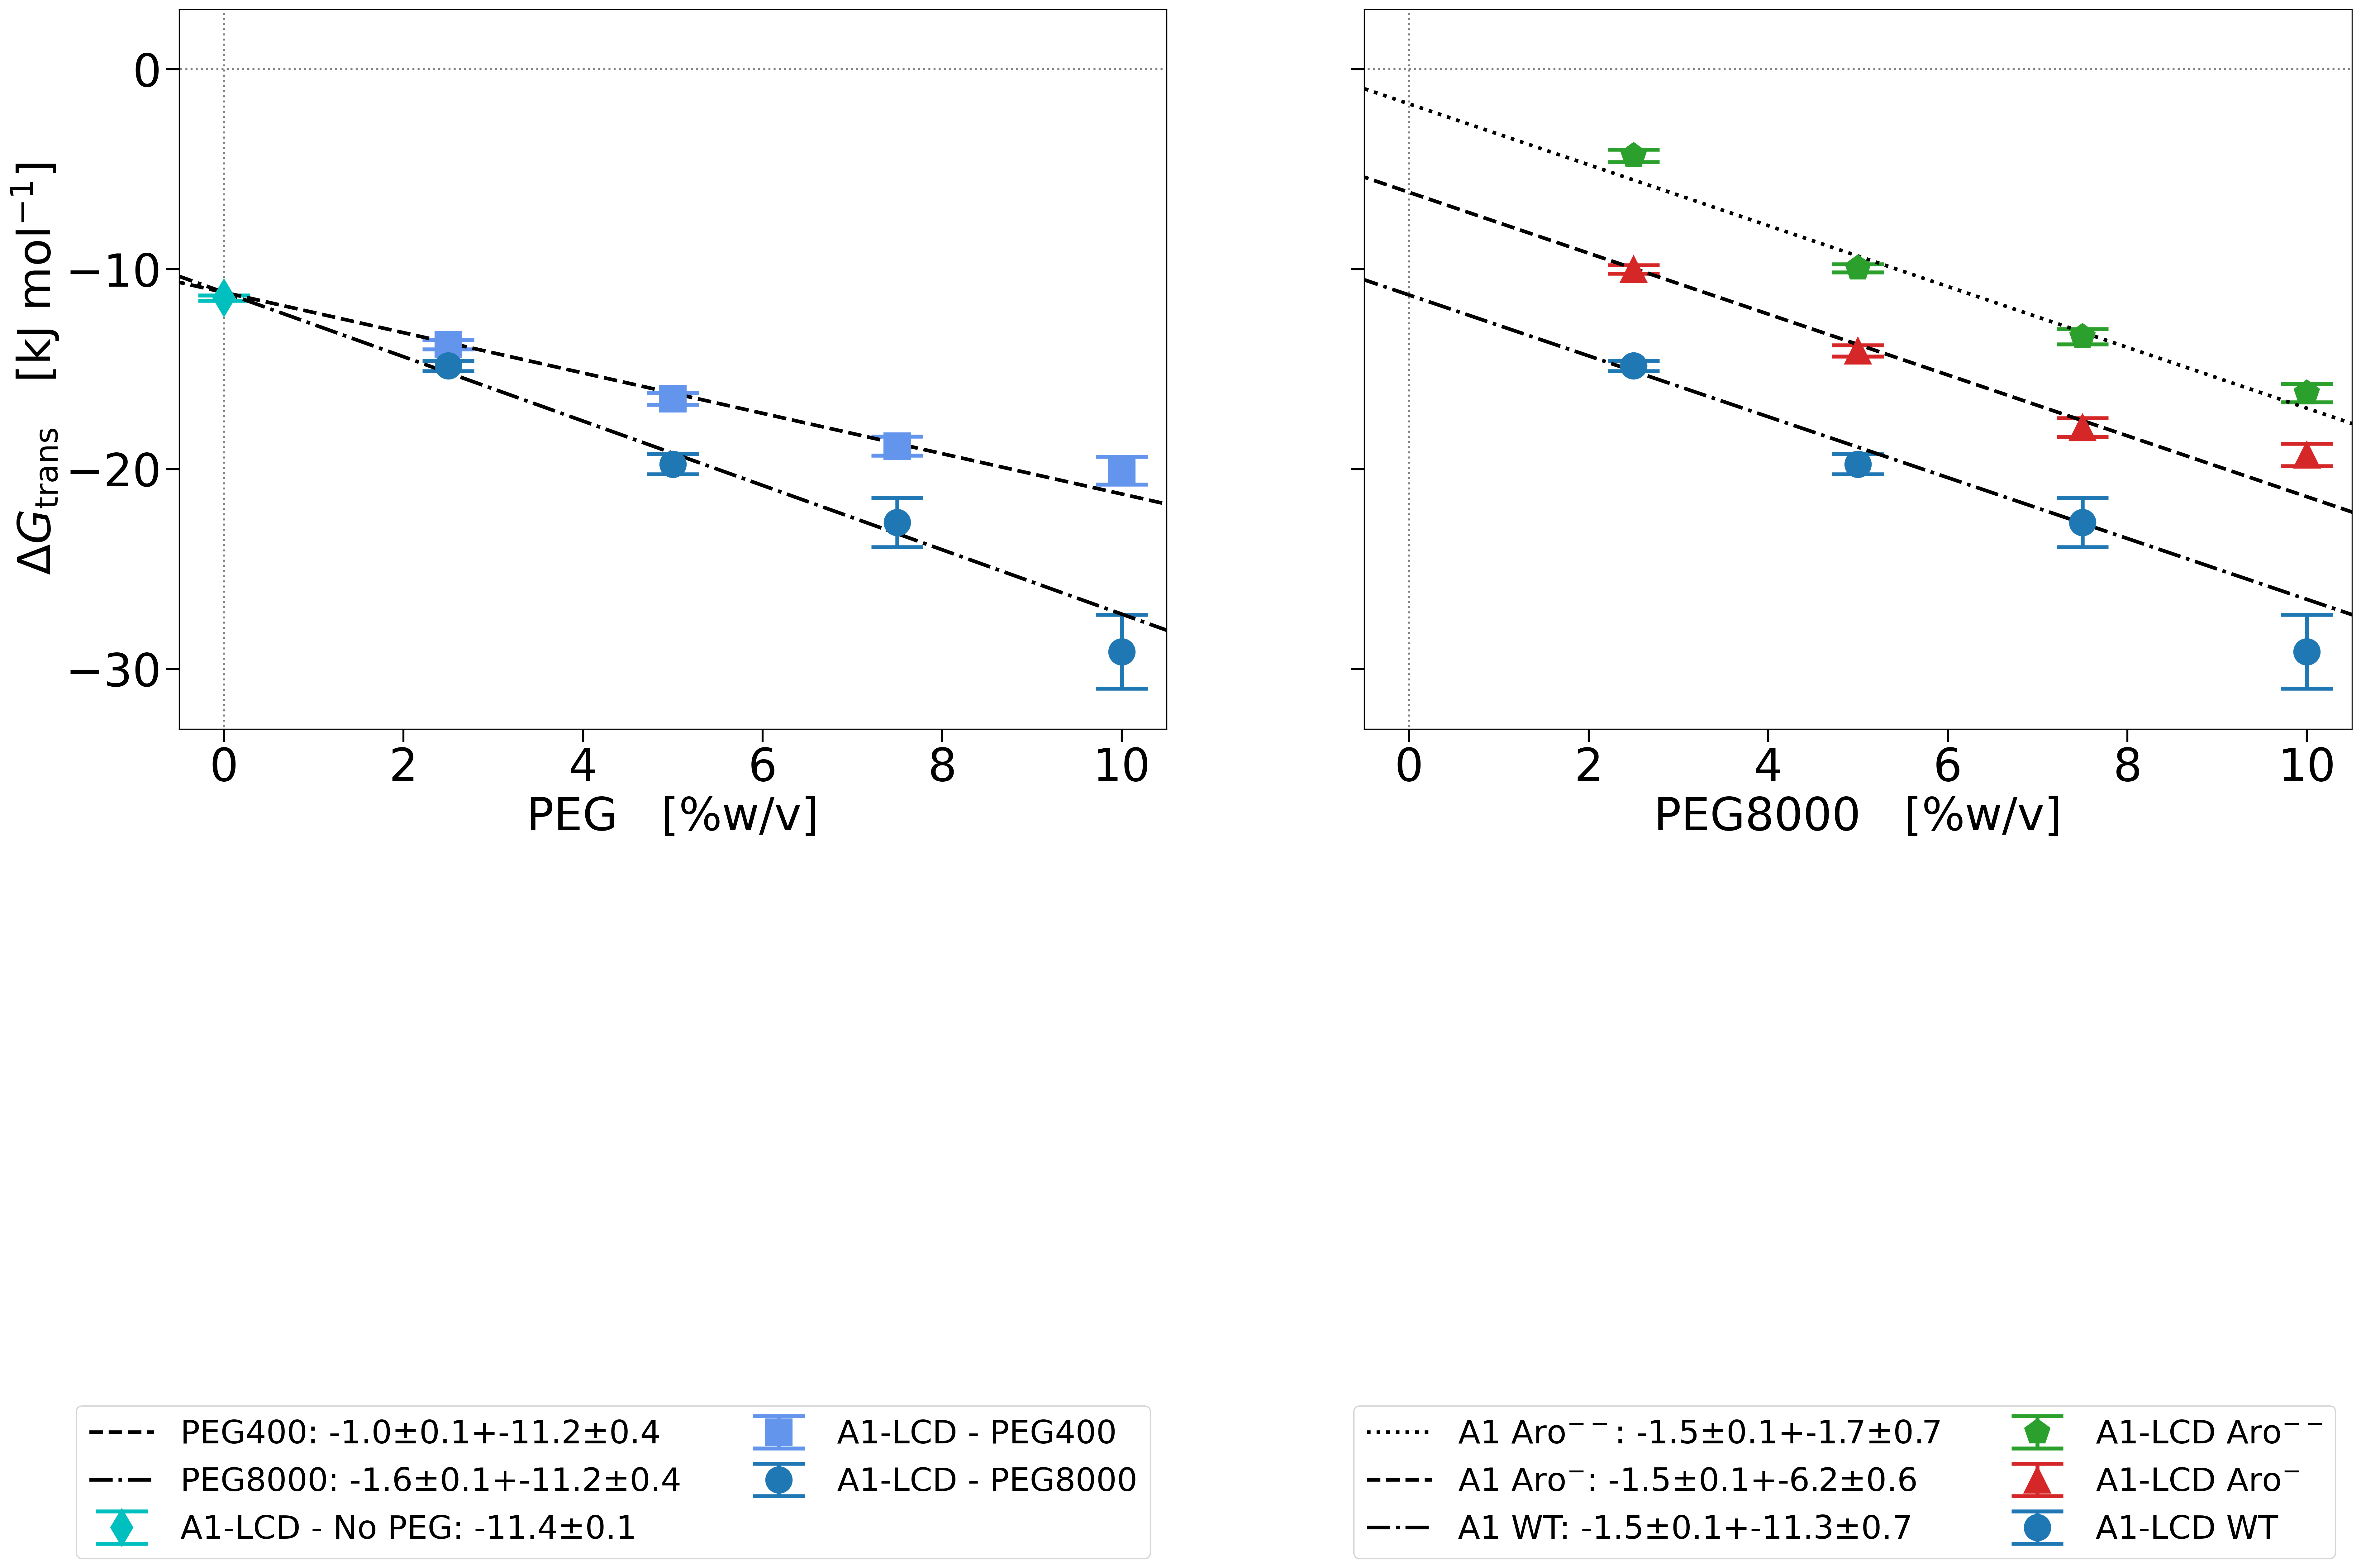

In [ ]:
xfit = np.linspace(-1,20)

fig, axs = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(30,10),dpi=300)

## A1 ##
## Average without PEG ##
datapoints_A1 = [ data.loc[('A1', p,0), 'dGtransferRatio'] for p in ['PEG400','PEG2000','PEG8000','PEG12000','PEG20000']]

axs[0].errorbar(x=[0],
                y=[np.mean(datapoints_A1)],
                yerr=[np.std(datapoints_A1)],
                marker='d', ls='',lw=2, label=F"A1-LCD - No PEG: {np.mean(datapoints_A1):.1f}±{np.std(datapoints_A1):.1f}",
                markersize=20,capsize=20,capthick=3,elinewidth=3,color='c')#'tab:blue')
# PEG400
axs[0].errorbar(x=data.loc[('A1', 'PEG400')].index[1:],
             y=data.loc[('A1', 'PEG400'), 'dGtransferRatio'].to_numpy()[1:],
             yerr=data.loc[('A1', 'PEG400'), 'dGtransferRatioE'].to_numpy()[1:],
             marker='s', ls='',lw=2, label=F"A1-LCD - PEG400", markersize=20,capsize=20,capthick=3,elinewidth=3,color='cornflowerblue')
# PEG8000
axs[0].errorbar(x=data.loc[('A1', 'PEG8000')].index[1:-3],
             y=data.loc[('A1', 'PEG8000'), 'dGtransferRatio'].to_numpy()[1:-3],
             yerr=data.loc[('A1', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:-3],
             marker='o', ls='',lw=2, label=F"A1-LCD - PEG8000", markersize=20,capsize=20,capthick=3,elinewidth=3,color='tab:blue')



axs[0].plot(xfit, f_lin(xfit,*[s_A1_400,glob_intercept]),ls='--',lw=2.8,color='k',
            label=F"PEG400: {s_A1_400:.1f}±{s_A1_400_err:.1f}+{glob_intercept:.1f}±{glob_intercept_err:.1f}")

axs[0].plot(xfit, f_lin(xfit,*[s_A1_8000,glob_intercept]),ls='-.',lw=2.8,color='k',
            label=F"PEG8000: {s_A1_8000:.1f}±{s_A1_8000_err:.1f}+{glob_intercept:.1f}±{glob_intercept_err:.1f}")



# axs[0].vlines(0.0,-60,0,color="grey",ls=':')
axs[0].vlines(0.0,-60,5,color="grey",ls=':')
axs[0].hlines(0.0,-5,20,color="grey",ls=':')
axs[0].set_xlim(-.5,10.5)
axs[0].set_ylim(-30,-8)


axs[0].legend(ncol=2,bbox_to_anchor=(00., -1.02, 1., .102), fontsize=25,frameon=True); #lower left  loc="upper right",
# plt.tight_layout();
axs[0].set_xlabel("PEG   [%w/v]", fontsize=35)
axs[0].set_ylabel(r"$\Delta G_{\mathrm{trans}}$   [kJ mol$^{-1}$]", fontsize=35)  #^{dil/den}
# axs[0].tick_params(axis='x', labelsize=35)
# axs[0].tick_params(axis='y', labelsize=35);


############
# Variants #
############ 
axs[1].errorbar(x=data.loc[('AroMM', 'PEG8000')].index[1:],
             y=data.loc[('AroMM', 'PEG8000'), 'dGtransferRatio'].to_numpy()[1:],
             yerr=data.loc[('AroMM', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:],
             marker='p', ls='',lw=2.5, label="A1-LCD Aro$^{--}$", markersize=20,capsize=20,capthick=3,elinewidth=3,color='tab:green')
axs[1].errorbar(x=data.loc[('AroM', 'PEG8000')].index[1:],
             y=data.loc[('AroM', 'PEG8000'), 'dGtransferRatio'].to_numpy()[1:],
             yerr=data.loc[('AroM', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:],
             marker='^', ls='',lw=2.5, label="A1-LCD Aro$^{-}$", markersize=20,capsize=20,capthick=3,elinewidth=3,color='tab:red')
axs[1].errorbar(x=data.loc[('A1', 'PEG8000')].index[1:-3],
             y=data.loc[('A1', 'PEG8000'), 'dGtransferRatio'].to_numpy()[1:-3],
             yerr=data.loc[('A1', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:-3],
             marker='o', ls='',lw=2.5, label=F"A1-LCD WT", markersize=20,capsize=20,capthick=3,elinewidth=3,color='tab:blue')

## Fitting with shared slope ##
# Linear fit of data Aro--
axs[1].plot(xfit, f_lin(xfit,*[glob_slope,i_AroMM]),ls=':',lw=2.8,color='k',
            label="A1 Aro$^{--}$"+F": {glob_slope:.1f}±{glob_slope_err:.1f}+{i_AroMM:.1f}±{i_AroMM_err:.1f}")

# Linear fit of data Aro-
axs[1].plot(xfit, f_lin(xfit,*[glob_slope,i_AroM]),ls='--',lw=2.8,color='k',
            label="A1 Aro$^{-}$"+F": {glob_slope:.1f}±{glob_slope_err:.1f}+{i_AroM:.1f}±{i_AroM_err:.1f}")

# Linear fit of data A1
axs[1].plot(xfit, f_lin(xfit,*[glob_slope,i_A1]),ls='-.',lw=2.8,color='k',
            label=F"A1 WT: {glob_slope:.1f}±{glob_slope_err:.1f}+{i_A1:.1f}±{i_A1_err:.1f}")

axs[1].vlines(0.0,-60,5,color="grey",ls=':')
axs[1].hlines(0.0,-5,20,color="grey",ls=':')
axs[1].set_xlim(-.5,10.5)
axs[1].set_ylim(-33,3)



axs[1].legend(ncol=2,bbox_to_anchor=(0., -1.02, 1., .102), fontsize=25,frameon=True); #lower left loc="lower left",
axs[1].set_xlabel("PEG8000   [%w/v]", fontsize=35)
# axs[1].tick_params(axis='x', labelsize=35)
# axs[1].tick_params(axis='y', labelsize=35);

axs[0].tick_params(axis='both', labelsize=35,length=10.0,width=1.5);
axs[1].tick_params(axis='both', labelsize=35,length=10.0,width=1.5);

# plt.tight_layout();
# fig.tight_layout(pad=1, w_pad=18);
fig.savefig("./figures/figure_3__top-pane__PEG-LLPS__A1-systems__13023025.pdf",
            facecolor='w',
            edgecolor='w',
            orientation='portrait',
            bbox_inches='tight');


#### F-test fits

In [ ]:
np.sum(np.power(values_sim-values_fit, 2)/np.power(error_sim,2))

In [238]:
chi2_A1_400

0.004432448876495273

In [327]:
xfit = np.array([2.5,5.0,7.5,10.0])


def chi_squared(values_sim, values_fit, error_sim):
    return np.sum(np.power(values_sim-values_fit, 2)/np.power(error_sim,2))


# Normal 2-parameter fit
chi2_A1_400= chi_squared(values_sim=data.loc[('A1', 'PEG400'), 'dGtransferRatio'].to_numpy()[1:], values_fit=f_lin(xfit,*popt_A1_400), error_sim=data.loc[('A1', 'PEG400'), 'dGtransferRatioE'].to_numpy()[1:])
chi2_A1_8K = chi_squared(values_sim=data.loc[('A1', 'PEG8000'), 'dGtransferRatio'].to_numpy()[1:5], values_fit=f_lin(xfit,*popt_A1_8K), error_sim=data.loc[('A1', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:5])
chi2_AroMM = chi_squared(values_sim=data.loc[('AroMM', 'PEG8000'), 'dGtransferRatio'].to_numpy()[1:], values_fit=f_lin(xfit,*popt_AroMM), error_sim=data.loc[('AroMM', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:])
chi2_AroM  = chi_squared(values_sim=data.loc[('AroM', 'PEG8000'), 'dGtransferRatio'].to_numpy()[1:], values_fit=f_lin(xfit,*popt_AroM), error_sim=data.loc[('AroM', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:])

chi2_A1 = (chi2_A1_400+chi2_A1_8K)
red_chi2_A1 = chi2_A1/8
chi2_A1var = (chi2_A1_8K+chi2_AroMM+chi2_AroM)
red_chi2_A1var = chi2_A1var/12


# Global parameter fit
chi2_A1_400_si= chi_squared(values_sim=data.loc[('A1',   'PEG400'), 'dGtransferRatio'].to_numpy()[1:],  values_fit=f_lin(xfit,s_A1_400, glob_intercept), error_sim=data.loc[('A1', 'PEG400'), 'dGtransferRatioE'].to_numpy()[1:])
chi2_A1_8K_si = chi_squared(values_sim=data.loc[('A1',   'PEG8000'),'dGtransferRatio'].to_numpy()[1:5], values_fit=f_lin(xfit,s_A1_8000,glob_intercept), error_sim=data.loc[('A1', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:5])
chi2_AroMM_sl = chi_squared(values_sim=data.loc[('AroMM','PEG8000'),'dGtransferRatio'].to_numpy()[1:],  values_fit=f_lin(xfit,glob_slope, i_AroMM), error_sim=data.loc[('AroMM', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:])
chi2_AroM_sl  = chi_squared(values_sim=data.loc[('AroM', 'PEG8000'),'dGtransferRatio'].to_numpy()[1:],  values_fit=f_lin(xfit,glob_slope, i_AroM),  error_sim=data.loc[('AroM', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:])
chi2_A1_8K_sl = chi_squared(values_sim=data.loc[('A1',   'PEG8000'),'dGtransferRatio'].to_numpy()[1:5], values_fit=f_lin(xfit,glob_slope, i_A1),    error_sim=data.loc[('A1', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:5])


chi2_A1_si = (chi2_A1_400_si+chi2_A1_8K_si)
red_chi2_A1_si = chi2_A1_si/8
chi2_A1var_sl = (chi2_A1_8K_sl+chi2_AroMM_sl+chi2_AroM_sl)
red_chi2_A1var_sl = chi2_A1var_sl/12


print("Separate fits:",chi2_A1,chi2_A1var)
print("Global fits:",chi2_A1_si,chi2_A1var_sl)

## F-test ##
# A1
F12_si = red_chi2_A1/red_chi2_A1_si
F21_si = red_chi2_A1_si/red_chi2_A1

print(F"F12 shared intercept:{F12_si:.4f} & F21 shared intercept:{F21_si:.4f}")

# A1 var
F12_sl = red_chi2_A1var/red_chi2_A1var_sl
F21_sl = red_chi2_A1var_sl/red_chi2_A1var

print(F"F12 shared slope:{F12_sl:.4f} & F21 shared slope:{F21_sl:.4f}")

Separate fits: 8.910503124168477 37.40442294365323
Global fits: 14.7401602775738 46.19550007874002
F12 shared intercept:0.6045 & F21 shared intercept:1.6542
F12 shared slope:0.8097 & F21 shared slope:1.2350


In [240]:
xfit = np.array([2.5,5.0,7.5,10.0])


def chi_squared(values_sim, values_fit, error_sim):
    return np.sum(np.power(values_sim-values_fit, 2)/np.power(error_sim,2))


# Normal 2-parameter fit
chi2_A1_400= chi_squared(values_sim=data.loc[('A1', 'PEG400'), 'dGtransferRatio'].to_numpy()[1:], values_fit=f_lin(xfit,*popt_A1_400), error_sim=data.loc[('A1', 'PEG400'), 'dGtransferRatioE'].to_numpy()[1:])
chi2_A1_8K = chi_squared(values_sim=data.loc[('A1', 'PEG8000'), 'dGtransferRatio'].to_numpy()[1:5], values_fit=f_lin(xfit,*popt_A1_8K), error_sim=data.loc[('A1', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:5])
chi2_AroMM = chi_squared(values_sim=data.loc[('AroMM', 'PEG8000'), 'dGtransferRatio'].to_numpy()[1:], values_fit=f_lin(xfit,*popt_AroMM), error_sim=data.loc[('AroMM', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:])
chi2_AroM  = chi_squared(values_sim=data.loc[('AroM', 'PEG8000'), 'dGtransferRatio'].to_numpy()[1:], values_fit=f_lin(xfit,*popt_AroM), error_sim=data.loc[('AroM', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:])

chi2_A1 = (chi2_A1_400+chi2_A1_8K)
red_chi2_A1 = chi2_A1/(8-4)
chi2_A1var = (chi2_A1_8K+chi2_AroMM+chi2_AroM)
red_chi2_A1var = chi2_A1var/(12-6)


# Global parameter fit
chi2_A1_400_si= chi_squared(values_sim=data.loc[('A1',   'PEG400'), 'dGtransferRatio'].to_numpy()[1:],  values_fit=f_lin(xfit,s_A1_400, glob_intercept), error_sim=data.loc[('A1', 'PEG400'), 'dGtransferRatioE'].to_numpy()[1:])
chi2_A1_8K_si = chi_squared(values_sim=data.loc[('A1',   'PEG8000'),'dGtransferRatio'].to_numpy()[1:5], values_fit=f_lin(xfit,s_A1_8000,glob_intercept), error_sim=data.loc[('A1', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:5])
chi2_AroMM_sl = chi_squared(values_sim=data.loc[('AroMM','PEG8000'),'dGtransferRatio'].to_numpy()[1:],  values_fit=f_lin(xfit,glob_slope, i_AroMM), error_sim=data.loc[('AroMM', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:])
chi2_AroM_sl  = chi_squared(values_sim=data.loc[('AroM', 'PEG8000'),'dGtransferRatio'].to_numpy()[1:],  values_fit=f_lin(xfit,glob_slope, i_AroM),  error_sim=data.loc[('AroM', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:])
chi2_A1_8K_sl = chi_squared(values_sim=data.loc[('A1',   'PEG8000'),'dGtransferRatio'].to_numpy()[1:5], values_fit=f_lin(xfit,glob_slope, i_A1),    error_sim=data.loc[('A1', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:5])


chi2_A1_si = (chi2_A1_400_si+chi2_A1_8K_si)
red_chi2_A1_si = chi2_A1_si/(8-3)
chi2_A1var_sl = (chi2_A1_8K_sl+chi2_AroMM_sl+chi2_AroM_sl)
red_chi2_A1var_sl = chi2_A1var_sl/(12-5)


print("Separate fits:",chi2_A1,chi2_A1var)
print("Global fits:",chi2_A1_si,chi2_A1var_sl)

## F-test ##
# A1
F12_si = red_chi2_A1/red_chi2_A1_si
F21_si = red_chi2_A1_si/red_chi2_A1

print(F"F12 shared intercept:{F12_si:.4f} & F21 shared intercept:{F21_si:.4f}")

# A1 var
F12_sl = red_chi2_A1var/red_chi2_A1var_sl
F21_sl = red_chi2_A1var_sl/red_chi2_A1var

print(F"F12 shared slope:{F12_sl:.4f} & F21 shared slope:{F21_sl:.4f}")

Separate fits: 4.411537206960095 77.89308256665448
Global fits: 8.158268638130451 49.009276153875966
F12 shared intercept:0.6759 & F21 shared intercept:1.4794
F12 shared slope:1.8542 & F21 shared slope:0.5393


In [346]:
from scipy.stats import f

def f_p_value(f_value, nu1, nu2):
    p_value = 1-f.cdf(f_value, nu1, nu2)
    return p_value

print(F"F12 shared intercept:{f_p_value(F12_si,8,8):.4f} & F21 shared intercept:{f_p_value(F21_si,8,8):.4f}")

print(F"F12 shared slope:{f_p_value(F12_sl,12,12):.4f} & F21 shared slope:{f_p_value(F21_sl,12,12):.4f}")

F12 shared intercept:0.7538 & F21 shared intercept:0.2462
F12 shared slope:0.6397 & F21 shared slope:0.3603


In [241]:
from scipy.stats import f

def f_p_value(f_value, nu1, nu2):
    p_value = 1-f.cdf(f_value, nu1, nu2)
    return p_value

print(F"F12 shared intercept:{f_p_value(F12_si,8-4,8-3):.4f} & F21 shared intercept:{f_p_value(F21_si,8-4,8-3):.4f}")

print(F"F12 shared slope:{f_p_value(F12_sl,12-6,12-5):.4f} & F21 shared slope:{f_p_value(F21_sl,12-6,12-5):.4f}")

F12 shared intercept:0.6371 & F21 shared intercept:0.3343
F12 shared slope:0.2189 & F21 shared slope:0.7653


In [347]:
print(F"F12 shared intercept:{f_p_value(F12_si,1,1):.4f} & F21 shared intercept:{f_p_value(F21_si,1,1):.4f}")

print(F"F12 shared slope:{f_p_value(F12_sl,1,1):.4f} & F21 shared slope:{f_p_value(F21_sl,1,1):.4f}")

F12 shared intercept:0.5793 & F21 shared intercept:0.4207
F12 shared slope:0.5335 & F21 shared slope:0.4665


In [347]:
print(F"F12 shared intercept:{f_p_value(F12_si,1,1):.4f} & F21 shared intercept:{f_p_value(F21_si,1,1):.4f}")

print(F"F12 shared slope:{f_p_value(F12_sl,1,1):.4f} & F21 shared slope:{f_p_value(F21_sl,1,1):.4f}")

F12 shared intercept:0.5793 & F21 shared intercept:0.4207
F12 shared slope:0.5335 & F21 shared slope:0.4665


#### Subpanel B: PS propensity vs aromatics

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

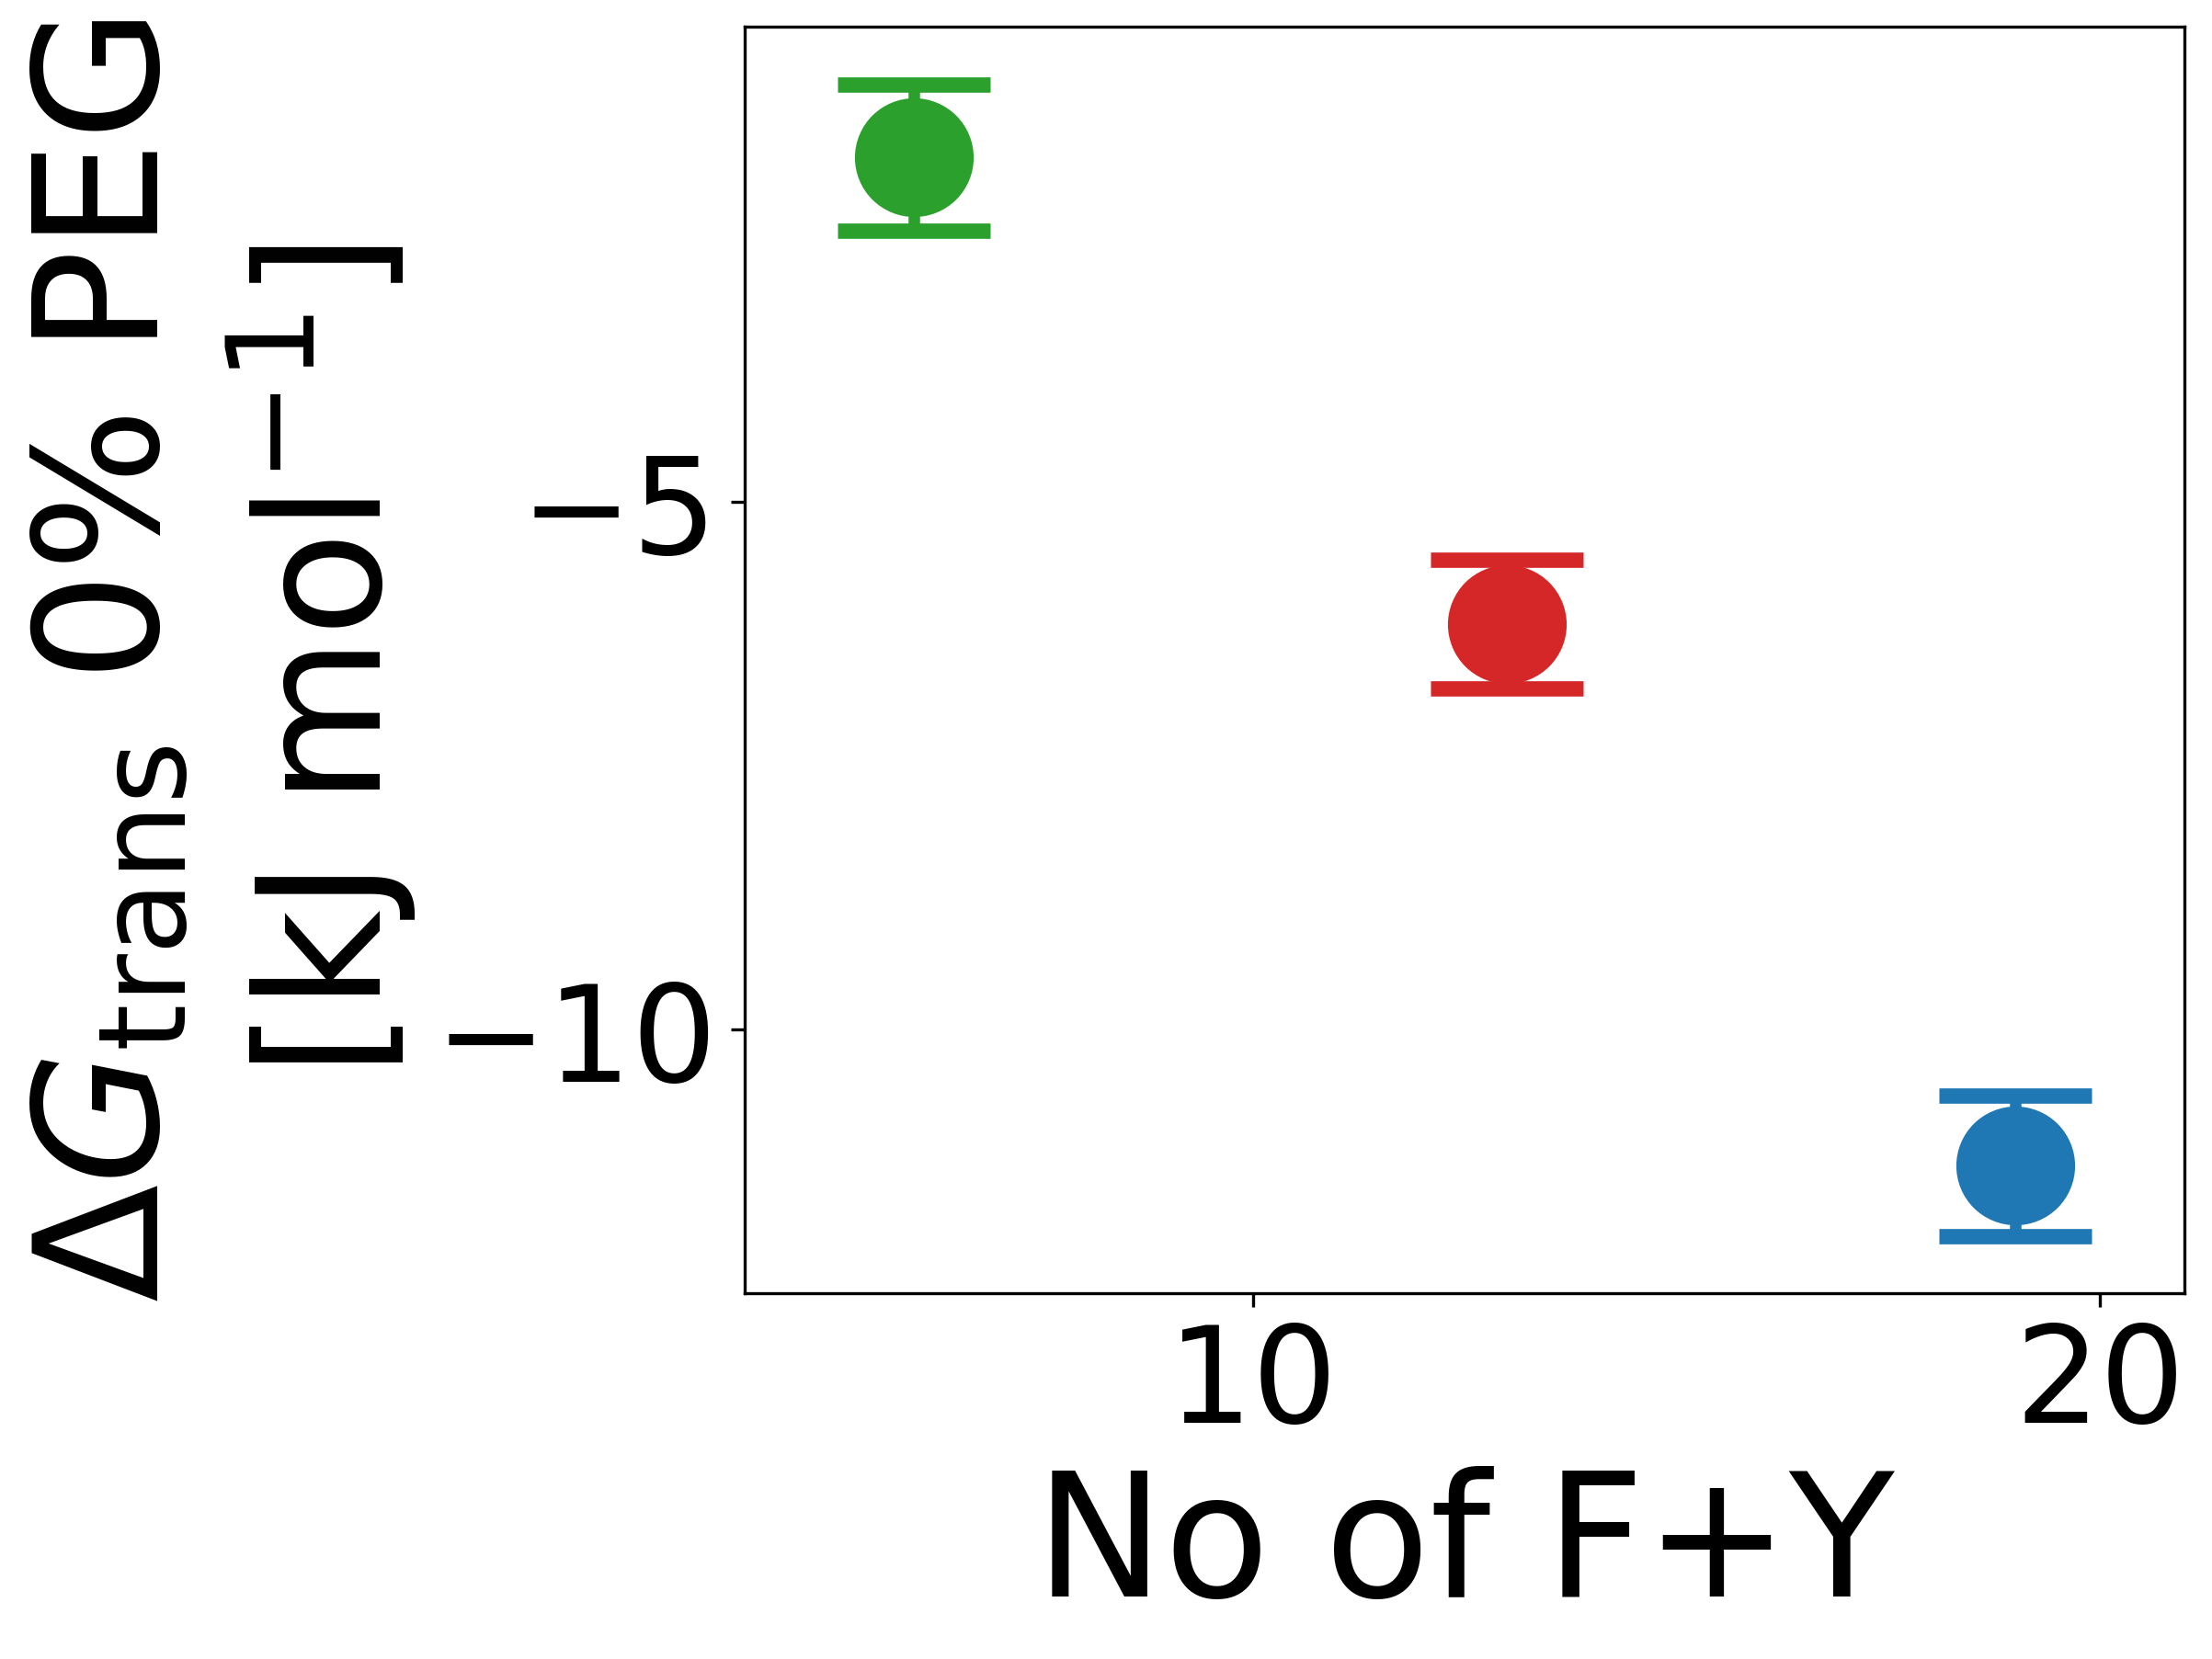

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(8,6),dpi=300)
axs.errorbar(x=6,y=i_AroMM,yerr=i_AroMM_err, marker='o', ls=':',lw=2.5, label=F"Aro--", markersize=30,capsize=20,capthick=4,elinewidth=3,color='tab:green')
axs.errorbar(x=13,y=i_AroM,yerr=i_AroM_err, marker='o', ls=':',lw=2.5, label=F"Aro-", markersize=30,capsize=20,capthick=4,elinewidth=3,color='tab:red')
axs.errorbar(x=19,y=i_A1,yerr=i_A1_err, marker='o', ls=':',lw=2.5, label=F"A1 WT", markersize=30,capsize=20,capthick=4,elinewidth=3,color='tab:blue')
axs.set_xlabel("No of F+Y", fontsize=45)
axs.set_ylabel("$\Delta G_\mathrm{trans}$ 0% PEG\n[kJ mol$^{-1}]$", fontsize=45)  #^{dil/den}
axs.set_xlim(4,21)
axs.tick_params(axis='x', labelsize=35)
axs.tick_params(axis='y', labelsize=35);
plt.tight_layout()
fig.savefig("./figures/extrapolated_dG_A1-variants__glob-fit.pdf")

### FIGURE 4

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

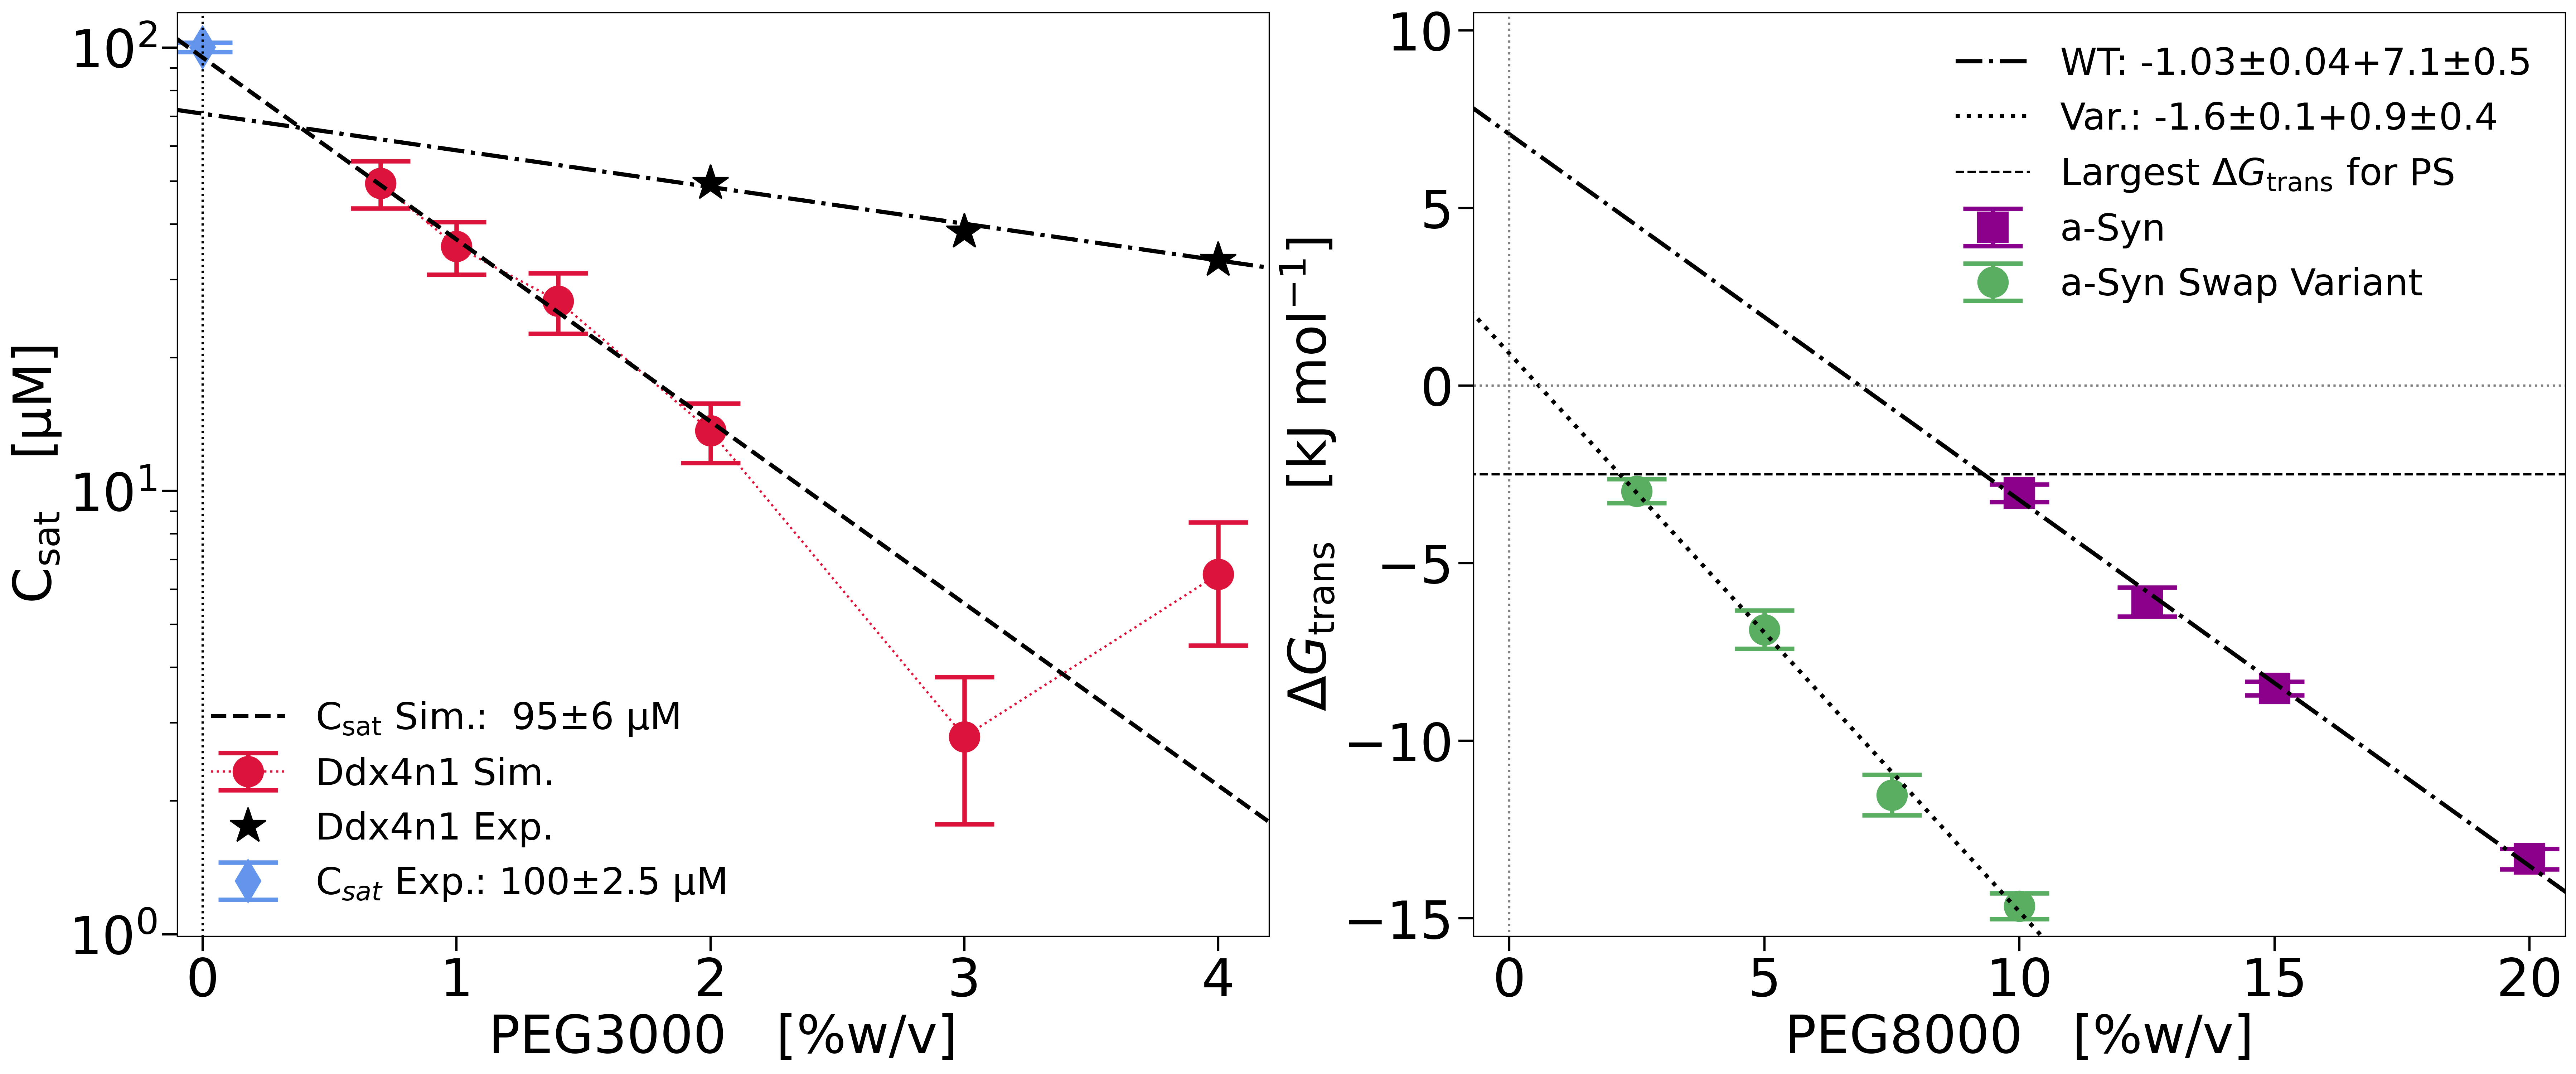

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(24,10),dpi=300)

######## Ddx4 ########
axs[0].errorbar(x=data_ddx4.loc[('Ddx4','PEG3000'),'Cdil'].index[1:-3],
            y=data_ddx4.loc[('Ddx4','PEG3000'),'Cdil'].to_numpy()[1:-3]*1000,
            yerr=data_ddx4.loc[('Ddx4','PEG3000'),'CdilSEM'].to_numpy()[1:-3]*1000,
            marker='o', barsabove=True, ls=':', label=F"Ddx4n1 Sim.", markersize=20,capsize=20,capthick=3,elinewidth=3,color='crimson')

## Experimentally determined Csat under same conditions as crowding ##
axs[0].errorbar(expData.index,expData['Average dilute phase (µM)'], label=F"Ddx4n1 Exp.",color='black',markersize=25,marker='*',ls='')

axs[0].errorbar(x=[0.0],
            y=np.mean(df_csat_ddx4['Csat_ave']),#np.mean([95.26920811,100.425748])/1000,
            yerr=wSD_ddx4,#np.std([95.26920811,100.425748])/1000,
            label="C$_{sat}$ Exp.: "+F"{np.mean(df_csat_ddx4['Csat_ave']):.0f}±{wSD_ddx4:.1f} µM",color='cornflowerblue',markersize=20,marker='d',ls='',
            barsabove=True,capsize=20,capthick=3,elinewidth=3)

# Fit on average
poptExp, pcovExp = curve_fit(f_exp, list(expData.index), expData['Average dilute phase (µM)'].to_numpy(), [1,-4])
xfit = np.linspace(-1.5,21.5)
axs[0].plot(xfit, f_exp(xfit,*poptExp),ls='-.',lw=2.8,color='k')#,label=F"Lin.fit: {popt[1]:.2f}x+{popt[0]:.2f}")

# Fit on simulation data
popt_ddx4, pcov_ddx4 = curve_fit(f_exp, data_ddx4.loc[('Ddx4','PEG3000'),'Cdil'].index[1:-5], data_ddx4.loc[('Ddx4','PEG3000'),'Cdil'].to_numpy()[1:-5]*1000, [1,0.1], maxfev=10000)
perr_ddx4 = np.sqrt(np.diag(pcov_ddx4))
axs[0].plot(xfit, f_exp(xfit,*popt_ddx4),ls='--',lw=2.8,color='k',label='C$_\mathrm{sat}$ Sim.:  '+F'{popt_ddx4[0]:.0f}±{perr_ddx4[0]:.0f} µM')#,label=F"Exp.fit: log({popt[1]:.2f})x+log({popt[0]:.2f})")

# axs[0].hlines(0.001,-1,4.2,ls=':',color='k')
axs[0].vlines(0.0,0.5,150,ls=':',color='k')

axs[0].set_xlim(-.1,4.2)
axs[0].set_ylim(0.99,120)
axs[0].set_yscale("log");
axs[0].set_xlabel("PEG3000   [%w/v]", fontsize=35);
axs[0].set_ylabel("C$_\mathrm{sat}$   [µM]", fontsize=35);
# axs[0].tick_params(axis='x', labelsize=35)
# axs[0].tick_params(axis='y', labelsize=35);
axs[0].tick_params(axis='both', labelsize=35,length=10.0,width=1.5);
axs[0].tick_params(axis='both', which='minor', labelsize=35,length=5.0,width=1.);
axs[0].legend(fontsize=25,loc="lower left", frameon=False);


## aSyn ##
# WT
axs[1].errorbar(x=data.loc[('aSyn', 'PEG8000')].index.to_numpy()[4:],
             y=data.loc[('aSyn', 'PEG8000'), 'dGtransferRatio'].to_numpy()[4:],
             yerr=data.loc[('aSyn', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[4:],
             marker='s', ls='',lw=2, label=r"a-Syn", markersize=20,capsize=20,capthick=3,elinewidth=3,barsabove=True,color='darkmagenta')

popt_aSyn, pcov_aSyn = curve_fit(f_lin, list(data.loc[('aSyn', 'PEG8000')].index)[-4:], data.loc[('aSyn', 'PEG8000'), 'dGtransferRatio'].to_numpy()[-4:], [1,-4],
                             sigma=data.loc[('aSyn', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[-4:], absolute_sigma=True)
axs[1].plot(xfit, f_lin(xfit,*popt_aSyn),ls='-.',lw=2.8,color='k',label=F"WT: {popt_aSyn[0]:.2f}±{np.sqrt(pcov_aSyn[0,0]):.2f}+{popt_aSyn[1]:.1f}±{np.sqrt(pcov_aSyn[1,1]):.1f}")

# Compact Variant
axs[1].errorbar(x=data_var.loc[('aSyn2745', 'PEG8000')].index.to_numpy()[1:],
             y=data_var.loc[('aSyn2745', 'PEG8000'), 'dGtransferRatio'].to_numpy()[1:],
             yerr=data_var.loc[('aSyn2745', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:],
             marker='o', ls='',lw=2, label=r"a-Syn Swap Variant", markersize=20,capsize=20,capthick=3,elinewidth=3,barsabove=True,color='#5aae61')

popt_aSynV, pcov_aSynV = curve_fit(f_lin, list(data_var.loc[('aSyn2745', 'PEG8000')].index)[1:], data_var.loc[('aSyn2745', 'PEG8000'), 'dGtransferRatio'].to_numpy()[-4:], [1,-4],
                             sigma=data_var.loc[('aSyn2745', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:], absolute_sigma=True)
axs[1].plot(xfit, f_lin(xfit,*popt_aSynV),ls=':',lw=2.8,color='k',label=F"Var.: {popt_aSynV[0]:.1f}±{np.sqrt(pcov_aSynV[0,0]):.1f}+{popt_aSynV[1]:.1f}±{np.sqrt(pcov_aSynV[1,1]):.1f}")


axs[1].vlines(0.0,-60,15,color="grey",ls=':')
axs[1].hlines(0.0,-5,21,color="grey",ls=':')
axs[1].hlines(-2.5,-5,21,color="k",ls='--',lw=1.5,label='Largest $\Delta G_\mathrm{trans}$ for PS')
axs[1].set_xlim(-.7,20.7)
axs[1].set_ylim(-15.5,10.5)


# plt.tight_layout();
axs[1].set_xlabel("PEG8000   [%w/v]", fontsize=35)
axs[1].set_ylabel("$\Delta G_\mathrm{trans}$   [kJ mol$^{-1}$]", fontsize=35)  #^{dil/den}
axs[1].tick_params(axis='both', labelsize=35,length=10.0,width=1.5);
axs[1].legend(fontsize=25,frameon=False);


fig.tight_layout();
fig.savefig("./figures/figure_4__Ddx4-aSyn__uM.pdf", facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight');

In [101]:
y1_a = data.loc[('aSyn','PEG8000'), 'dGtransferRatio'].to_numpy()[-4:]
y2_a = data_var.loc[('aSyn2745', 'PEG8000'), 'dGtransferRatio'].to_numpy()[1:]

comboY = np.array([y1, y2]).ravel()

y1e_a = data.loc[('aSyn','PEG8000'), 'dGtransferRatioE'].to_numpy()[-4:]
y2e_a = data_var.loc[('aSyn2745', 'PEG8000'), 'dGtransferRatioE'].to_numpy()[1:]

comboYe = np.array([y1e_a, y2e_a]).ravel()

h = np.array([2.5,5.0,7.5,10.])
h1 = np.array([10.,12.5,15.,20.])
comboX = np.array([h, h1]).ravel()


def mod1(data, a, b, c): # not all parameters are used here
        return a * data + b


def mod2(data, a, b, c): # not all parameters are used here
        return a * data + c

def comboFunc_glob_sl(comboData, a, b, c):
    # single data set passed in, extract separate data
    extract1 = comboData[:len(y1)] # first data
    extract2 = comboData[len(y1):len(y1)+len(y2)] # second data
    result1 = mod1(extract1, a, b, c)
    result2 = mod2(extract2, a, b, c)
    return np.array([result1, result2]).ravel()


# some initial parameter values
initialParameters = np.array([-1.3, 1.0, 7.0])

# curve fit the combined data to the combined function
fittedParameters_glob_aSyn, pcov_glob_aSyn = curve_fit(f=comboFunc_glob_sl, xdata=comboX, ydata=comboY, p0=initialParameters,sigma=comboYe)

# values for display of fitted function
glob_slope, i_aSyn, i_aSynV = fittedParameters_glob_aSyn
glob_slope_err, i_aSyn_err, i_aSynV_err = np.sqrt(pcov_glob_aSyn.diagonal())


# print(fittedParameters_int)
# print(np.sqrt(pcov.diagonal()))

/tmp/ipykernel_21447/2953158047.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  y1_a = data.loc[('aSyn','PEG8000'), 'dGtransferRatio'].to_numpy()[-4:]
/tmp/ipykernel_21447/2953158047.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  y1e_a = data.loc[('aSyn','PEG8000'), 'dGtransferRatioE'].to_numpy()[-4:]


#### F-tests aSyn

In [105]:
xfit_var = np.array([2.5,5.0,7.5,10.0])


def chi_squared(values_sim, values_fit, error_sim):
    return np.sum(np.power(values_sim-values_fit, 2)/np.power(error_sim,2))


# Normal parameter fit
chi2_aSyn_8K  = chi_squared(values_sim=y1_a,
                            values_fit=f_lin(h1,*popt_aSyn),
                            error_sim=y1e_a)
chi2_aSynV_8K = chi_squared(values_sim=y2_a,
                            values_fit=f_lin(h,*popt_aSynV),
                            error_sim=y2e_a)

chi2_aSyn_n = (chi2_aSyn_8K+chi2_aSynV_8K)
red_chi2_aSyn_n = chi2_aSyn_n/8


# Global parameter fit
chi2_aSyn_8K_g  = chi_squared(values_sim=y1_a,
                            values_fit=f_lin(h1,*[glob_slope,i_aSyn]),
                            error_sim=y1e_a)
chi2_aSynV_8K_g = chi_squared(values_sim=y2_a,
                            values_fit=f_lin(h,*[glob_slope,i_aSynV]),
                            error_sim=y2e_a)

chi2_aSyn_g = (chi2_aSyn_8K_g+chi2_aSynV_8K_g)
red_chi2_aSyn_g = chi2_aSyn_g/8


print("Separate fits:",chi2_aSyn_n,red_chi2_aSyn_n)
print("Global fits:",chi2_aSyn_g,red_chi2_aSyn_g)

## F-test ##
# A1
F12_aSyn = red_chi2_aSyn_n/red_chi2_aSyn_g
F21_aSyn = red_chi2_aSyn_g/red_chi2_aSyn_n

print(F"F12 shared intercept:{F12_aSyn:.4f} & F21 shared intercept:{F21_aSyn:.4f}")


Separate fits: 3.762444070371446 0.47030550879643074
Global fits: 12013.48839203575 1501.6860490044687
F12 shared intercept:0.0003 & F21 shared intercept:3193.0012


## SI Figures

### Figure S1

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

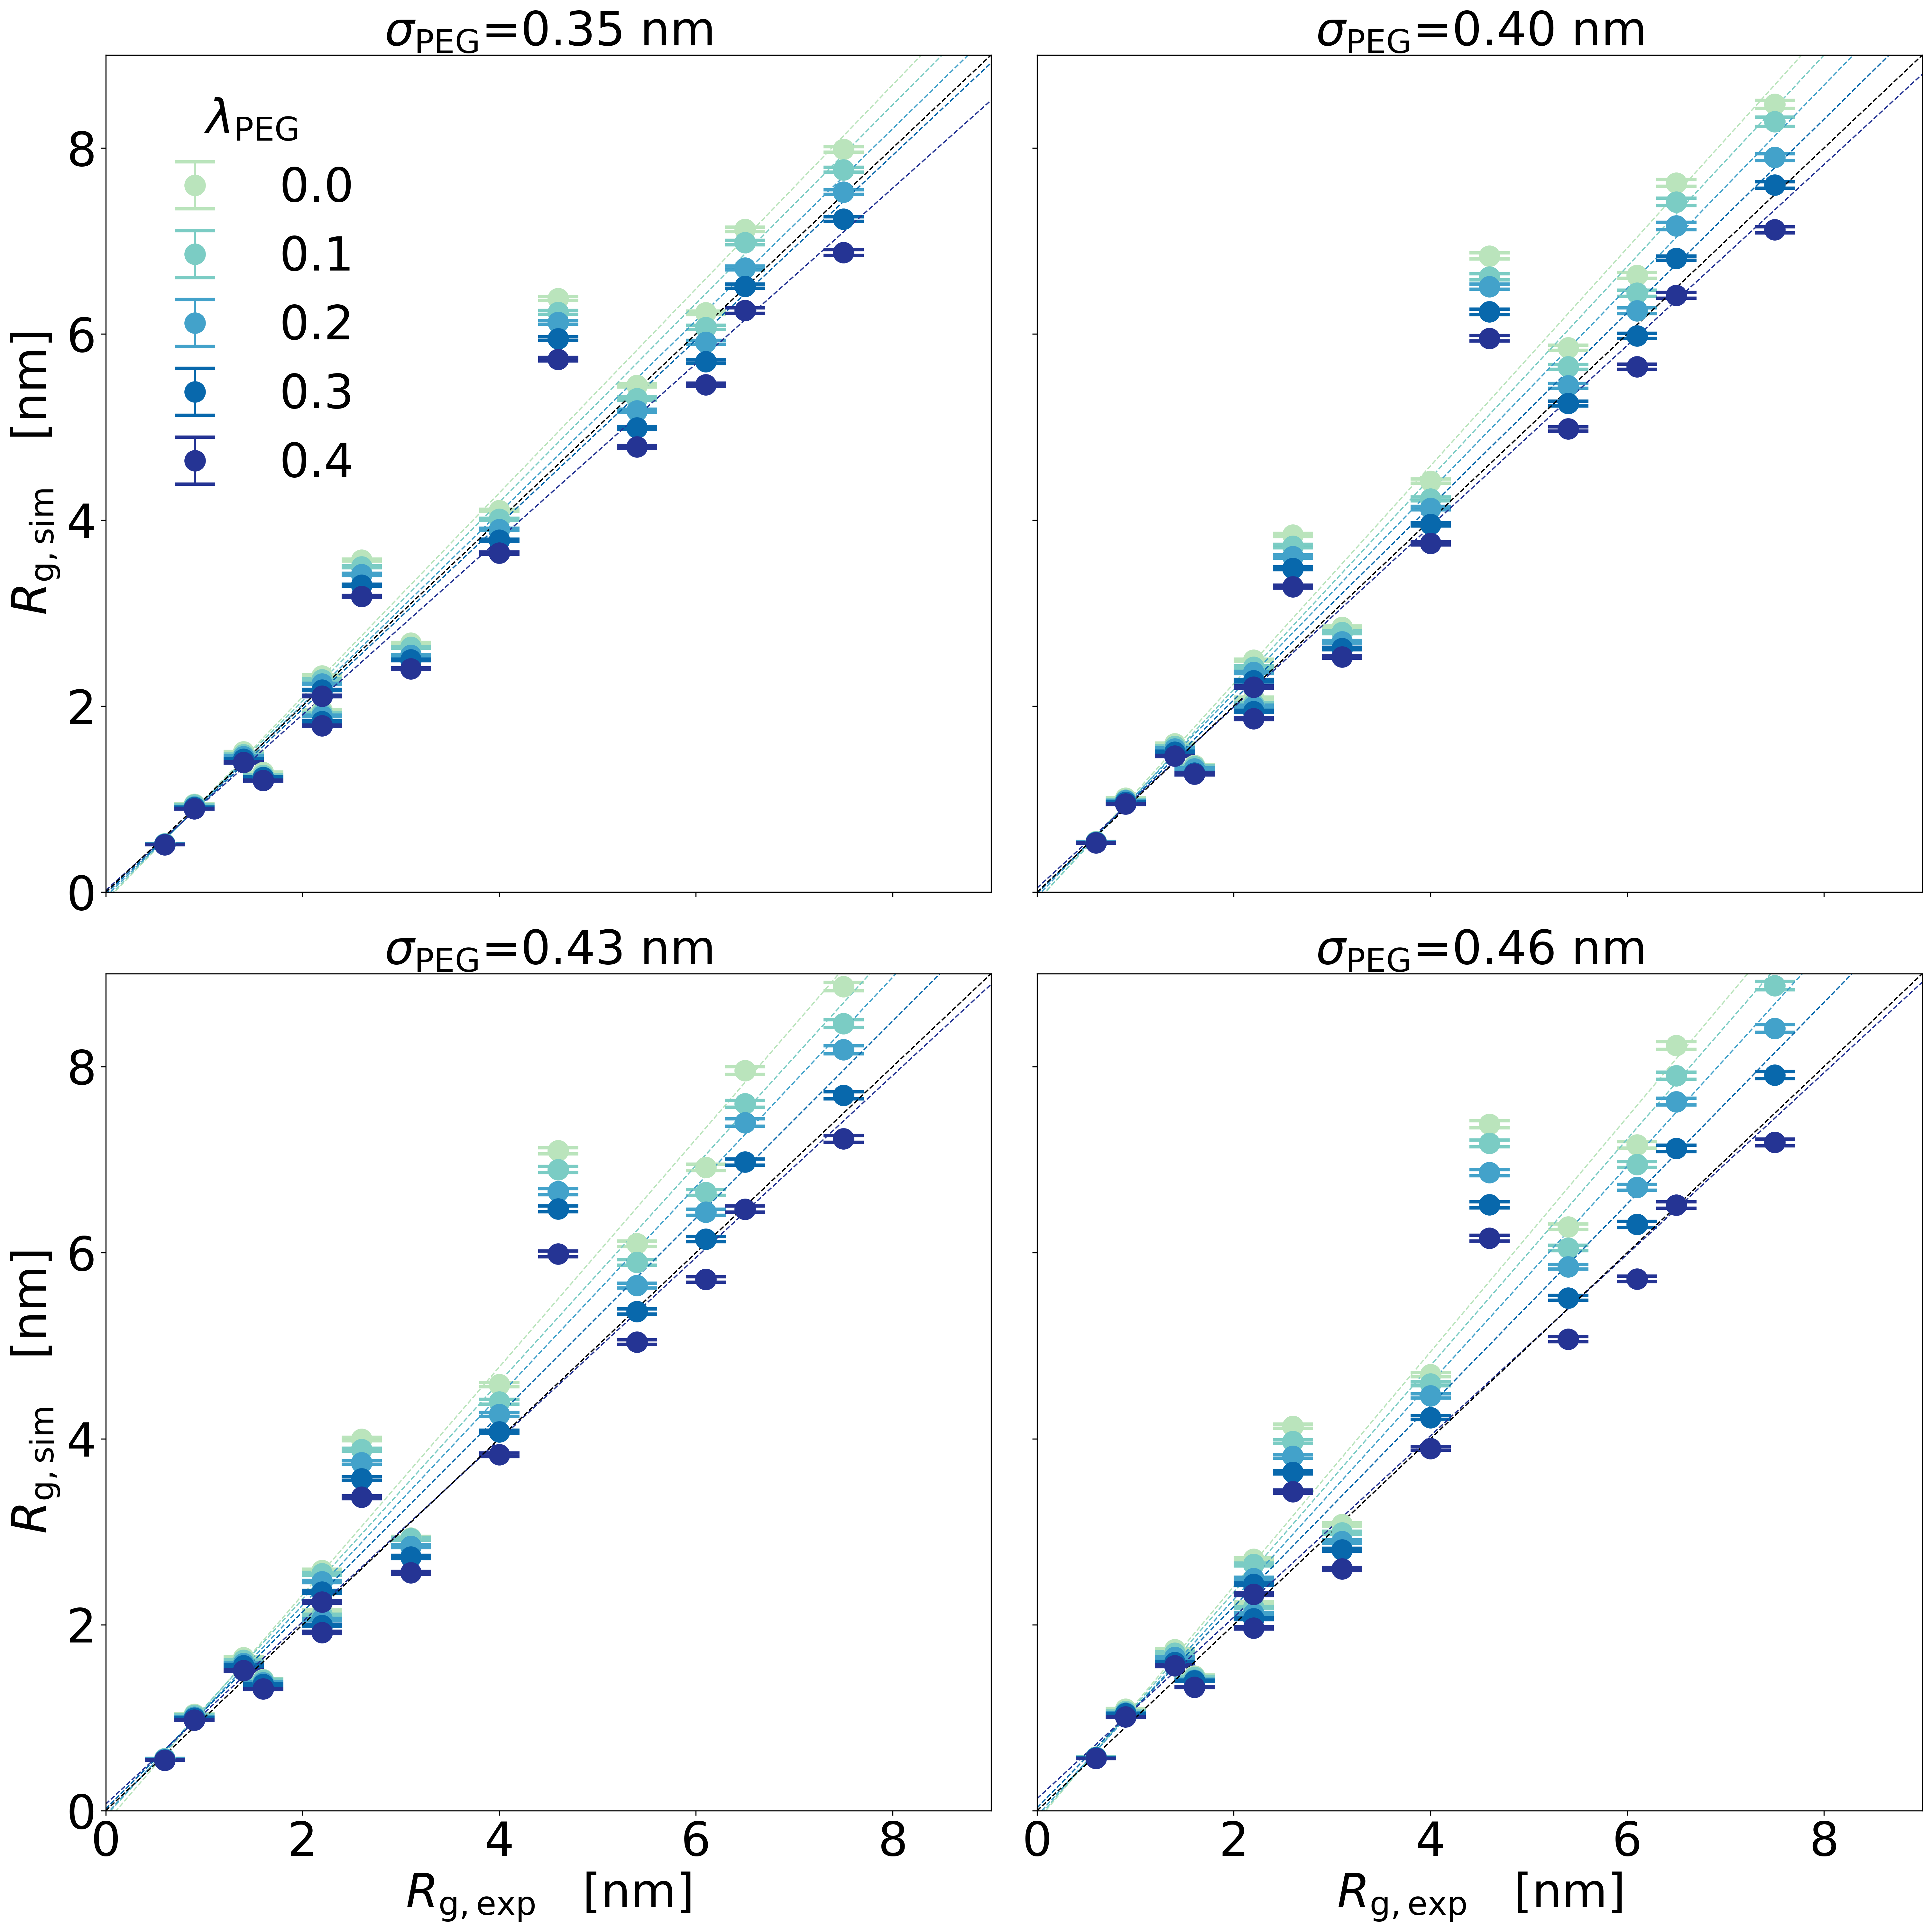

In [ ]:
colours = ['#bae4bc','#7bccc4','#43a2ca','#0868ac','#253494'] #['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

fig, axs = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True,figsize=(20,20),dpi=300)

for j, s in zip([[0,0],[0,1],[1,0],[1,1]],[0.35,0.4,0.43,0.46]):
    for i, l in enumerate([0.0,0.1,0.2,0.3,0.4]):
        axs[j[0],j[1]].errorbar(x=rg_values_scp.loc[:,l,s]['expRg'].to_numpy(),
                        y=rg_values_scp.loc[:,l,s]['simRg'].to_numpy(),
                        yerr=rg_values_scp.loc[:,l,s]['simRgSEM'].to_numpy(),
                        marker='o', barsabove=False, ls='', label=F"{l}", markersize=15, capsize=15,capthick=2.5,color=colours[i])

        # Fit on average
        popt, _ = curve_fit(f_lin, rg_values_scp.loc[:,l,s]['expRg'].to_numpy(), rg_values_scp.loc[:,l,s]['simRg'].to_numpy(), [1,-4])
        xfit = np.linspace(0,10)
        axs[j[0],j[1]].plot(xfit, f_lin(xfit,*popt),ls='--',lw=1.,color=colours[i])#,label=F"Lin.fit: {popt[1]:.2f}x+{popt[0]:.2f}")

    axs[j[0],j[1]].set_xlim(0,9)
    axs[j[0],j[1]].set_ylim(0,9)
    axs[j[0],j[1]].tick_params(axis="x", labelsize=35) 
    axs[j[0],j[1]].tick_params(axis="y", labelsize=35) 
    axs[j[0],j[1]].plot(xfit, f_lin(xfit,1,0),ls='--',lw=1.,color='k')

axs[0,0].set_ylabel(r"$R_\mathrm{g,sim}$   [nm]", fontsize=35)
axs[1,0].set_xlabel(r"$R_\mathrm{g,exp}$   [nm]", fontsize=35)
axs[1,0].set_ylabel(r"$R_\mathrm{g,sim}$   [nm]", fontsize=35)
axs[1,1].set_xlabel(r"$R_\mathrm{g,exp}$   [nm]", fontsize=35)

axs[0,0].set_title(r"$\sigma_\mathrm{PEG}$=0.35 nm", fontsize=35)
axs[0,1].set_title(r"$\sigma_\mathrm{PEG}$=0.40 nm", fontsize=35)
axs[1,0].set_title(r"$\sigma_\mathrm{PEG}$=0.43 nm", fontsize=35)
axs[1,1].set_title(r"$\sigma_\mathrm{PEG}$=0.46 nm", fontsize=35)

axs[0,0].legend(frameon=False, title="$\lambda_\mathrm{PEG}$", fontsize=35, title_fontsize=35)

fig.tight_layout()
fig.savefig("./figures/sup-figure__PEG-single-chain__rg-v-rg__all-sigmas.pdf")

### Figure S2

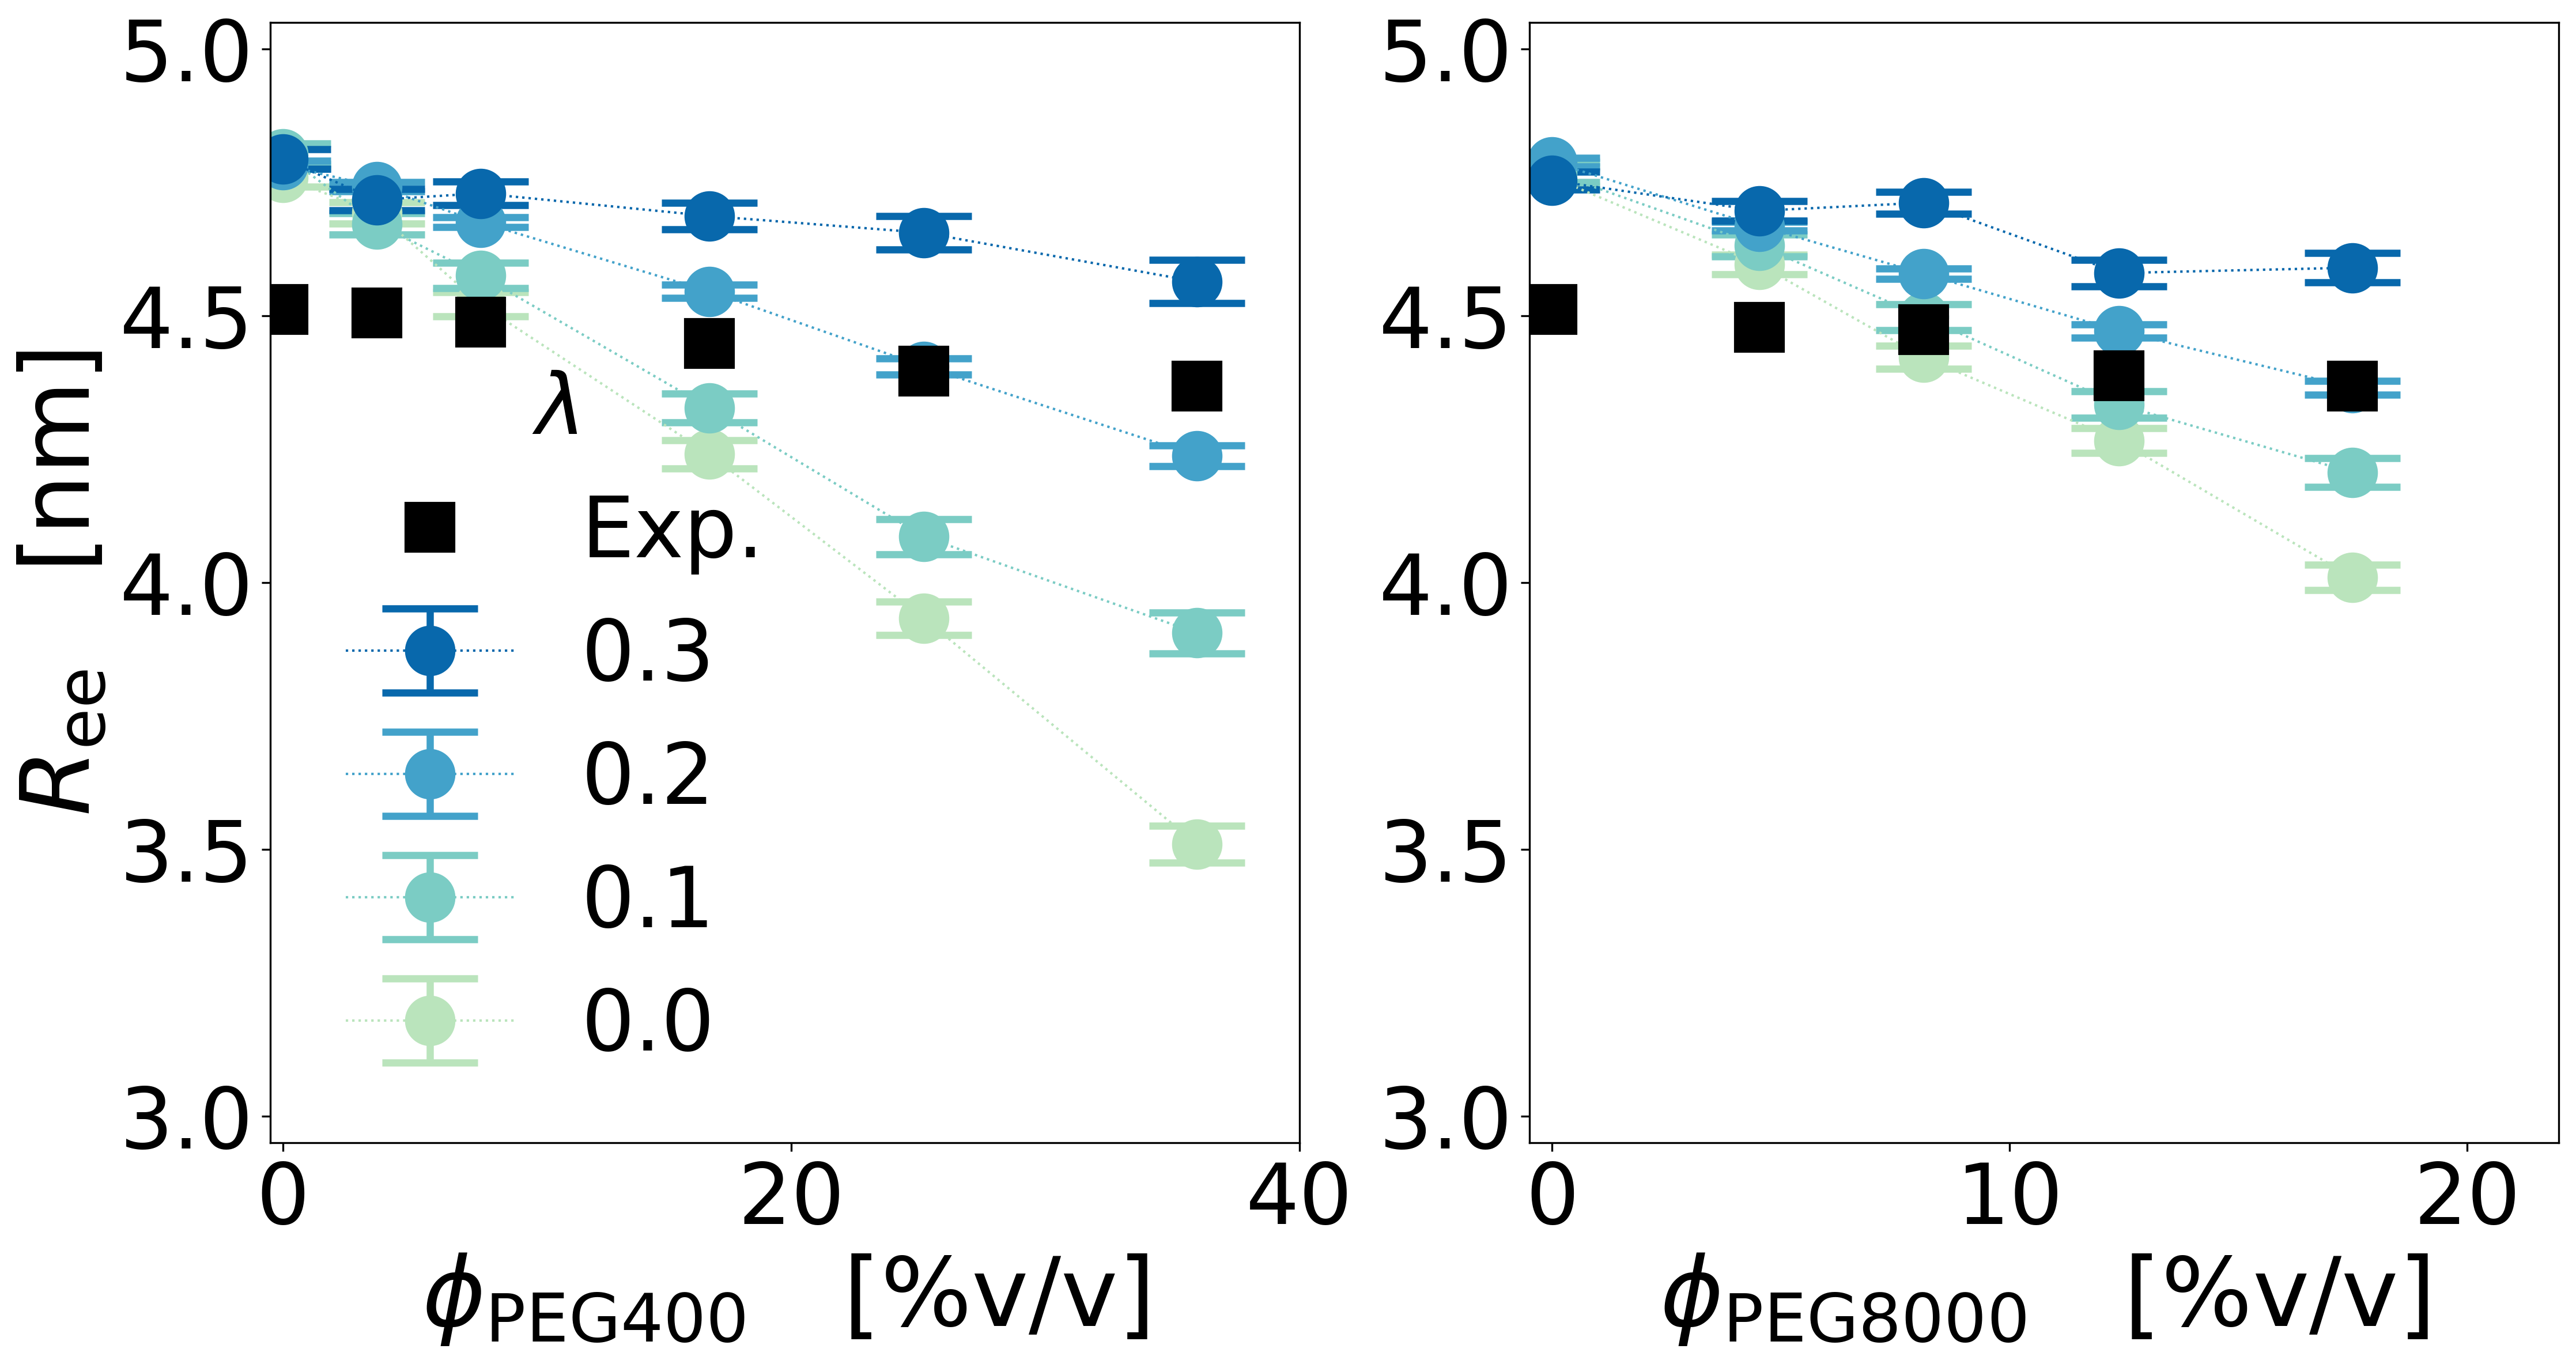

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,8),dpi=300)  #,sharey=True

subs = []
nrows = 3
ncols = 2

# size_exp = 280
col_exp  = 'k'
marks = {'PEG400':'o', 'PEG8000':'o'}
colors = ['#bae4bc','#7bccc4','#43a2ca','#0868ac']


for l, col in zip([0.0, 0.1, 0.2, 0.3],colors):
    for i, peg in enumerate(["PEG400","PEG8000"]):
        axs[i].errorbar(x=IN[(l,peg)]['vv'],
                        y=IN[(l,peg)]['simRee'],
                        yerr=IN[(l,peg)]['simReeSEM'],
                        marker=marks[peg], ls=':', lw=1, label=F"{l}",color=col, barsabove=False,markersize=20,capsize=20,capthick=3,elinewidth=3)

# Plot experimental data points.
axs[0].errorbar(x=IN[('exp',"PEG400")]['vv'],
                y=IN[('exp','PEG400')]['expRee'],
                label='Exp.', ls='',markersize=20, c=col_exp,marker='s')
axs[1].errorbar(x=IN[('exp',"PEG8000")]['vv'],
                y=IN[('exp','PEG8000')]['expRee'],
                label='Exp.', ls='',#s=size_exp,
                c=col_exp,marker='s',markersize=20)
# General settings plot
axs[0].set_xlim(-0.5,40)
axs[0].set_ylim(2.95,5.05)
axs[0].set_xlabel("$\phi_\mathrm{PEG400}$   [%v/v]", fontsize=40)
axs[0].set_ylabel(r"$R_\mathrm{ee}$   [nm]", fontsize=40)
axs[0].tick_params(axis="x", labelsize=35) 
axs[0].tick_params(axis="y", labelsize=35)

axs[1].set_xlim(-0.5,22)
axs[1].set_ylim(2.95,5.05)
axs[1].set_xlabel("$\phi_\mathrm{PEG8000}$   [%v/v]", fontsize=40)
# axs[1].set_ylabel(r"R${g}$  /  nm", fontsize=25)
axs[1].set_xticks([0,10,20])
axs[1].tick_params(axis="x", labelsize=35) 
axs[1].tick_params(axis="y", labelsize=35)
# axs[1].sharey(axs[0])

axs[0].legend(title='$\lambda$',fontsize=35, title_fontsize=35, loc='lower left', frameon=False, reverse=True);

fig.tight_layout()
fig.savefig("./figures/sup_figure__IN__Ree-PEG.pdf", orientation='landscape')

### Figure S3

/tmp/ipykernel_711317/1289041221.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  axs[0,0].errorbar(x=data.loc[('A1','PEG400'),'Cdil'].index[1:],
/tmp/ipykernel_711317/1289041221.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  y=data.loc[('A1','PEG400'),'Cdil'].to_numpy()[1:]*factor,
/tmp/ipykernel_711317/1289041221.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  yerr=data.loc[('A1','PEG400'),'CdilSEM'].to_numpy()[1:]*factor,
/tmp/ipykernel_711317/1289041221.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  axs[0,1].errorbar(x=data.loc[('A1','PEG400'),'Cden'].index[1:],
/tmp/ipykernel_711317/1289041221.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  y=data.loc[('A1','PEG400'),'Cden'].to_numpy()[1:]*factor,
/tmp/ipykernel_711317/1289041221.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  yerr=dat

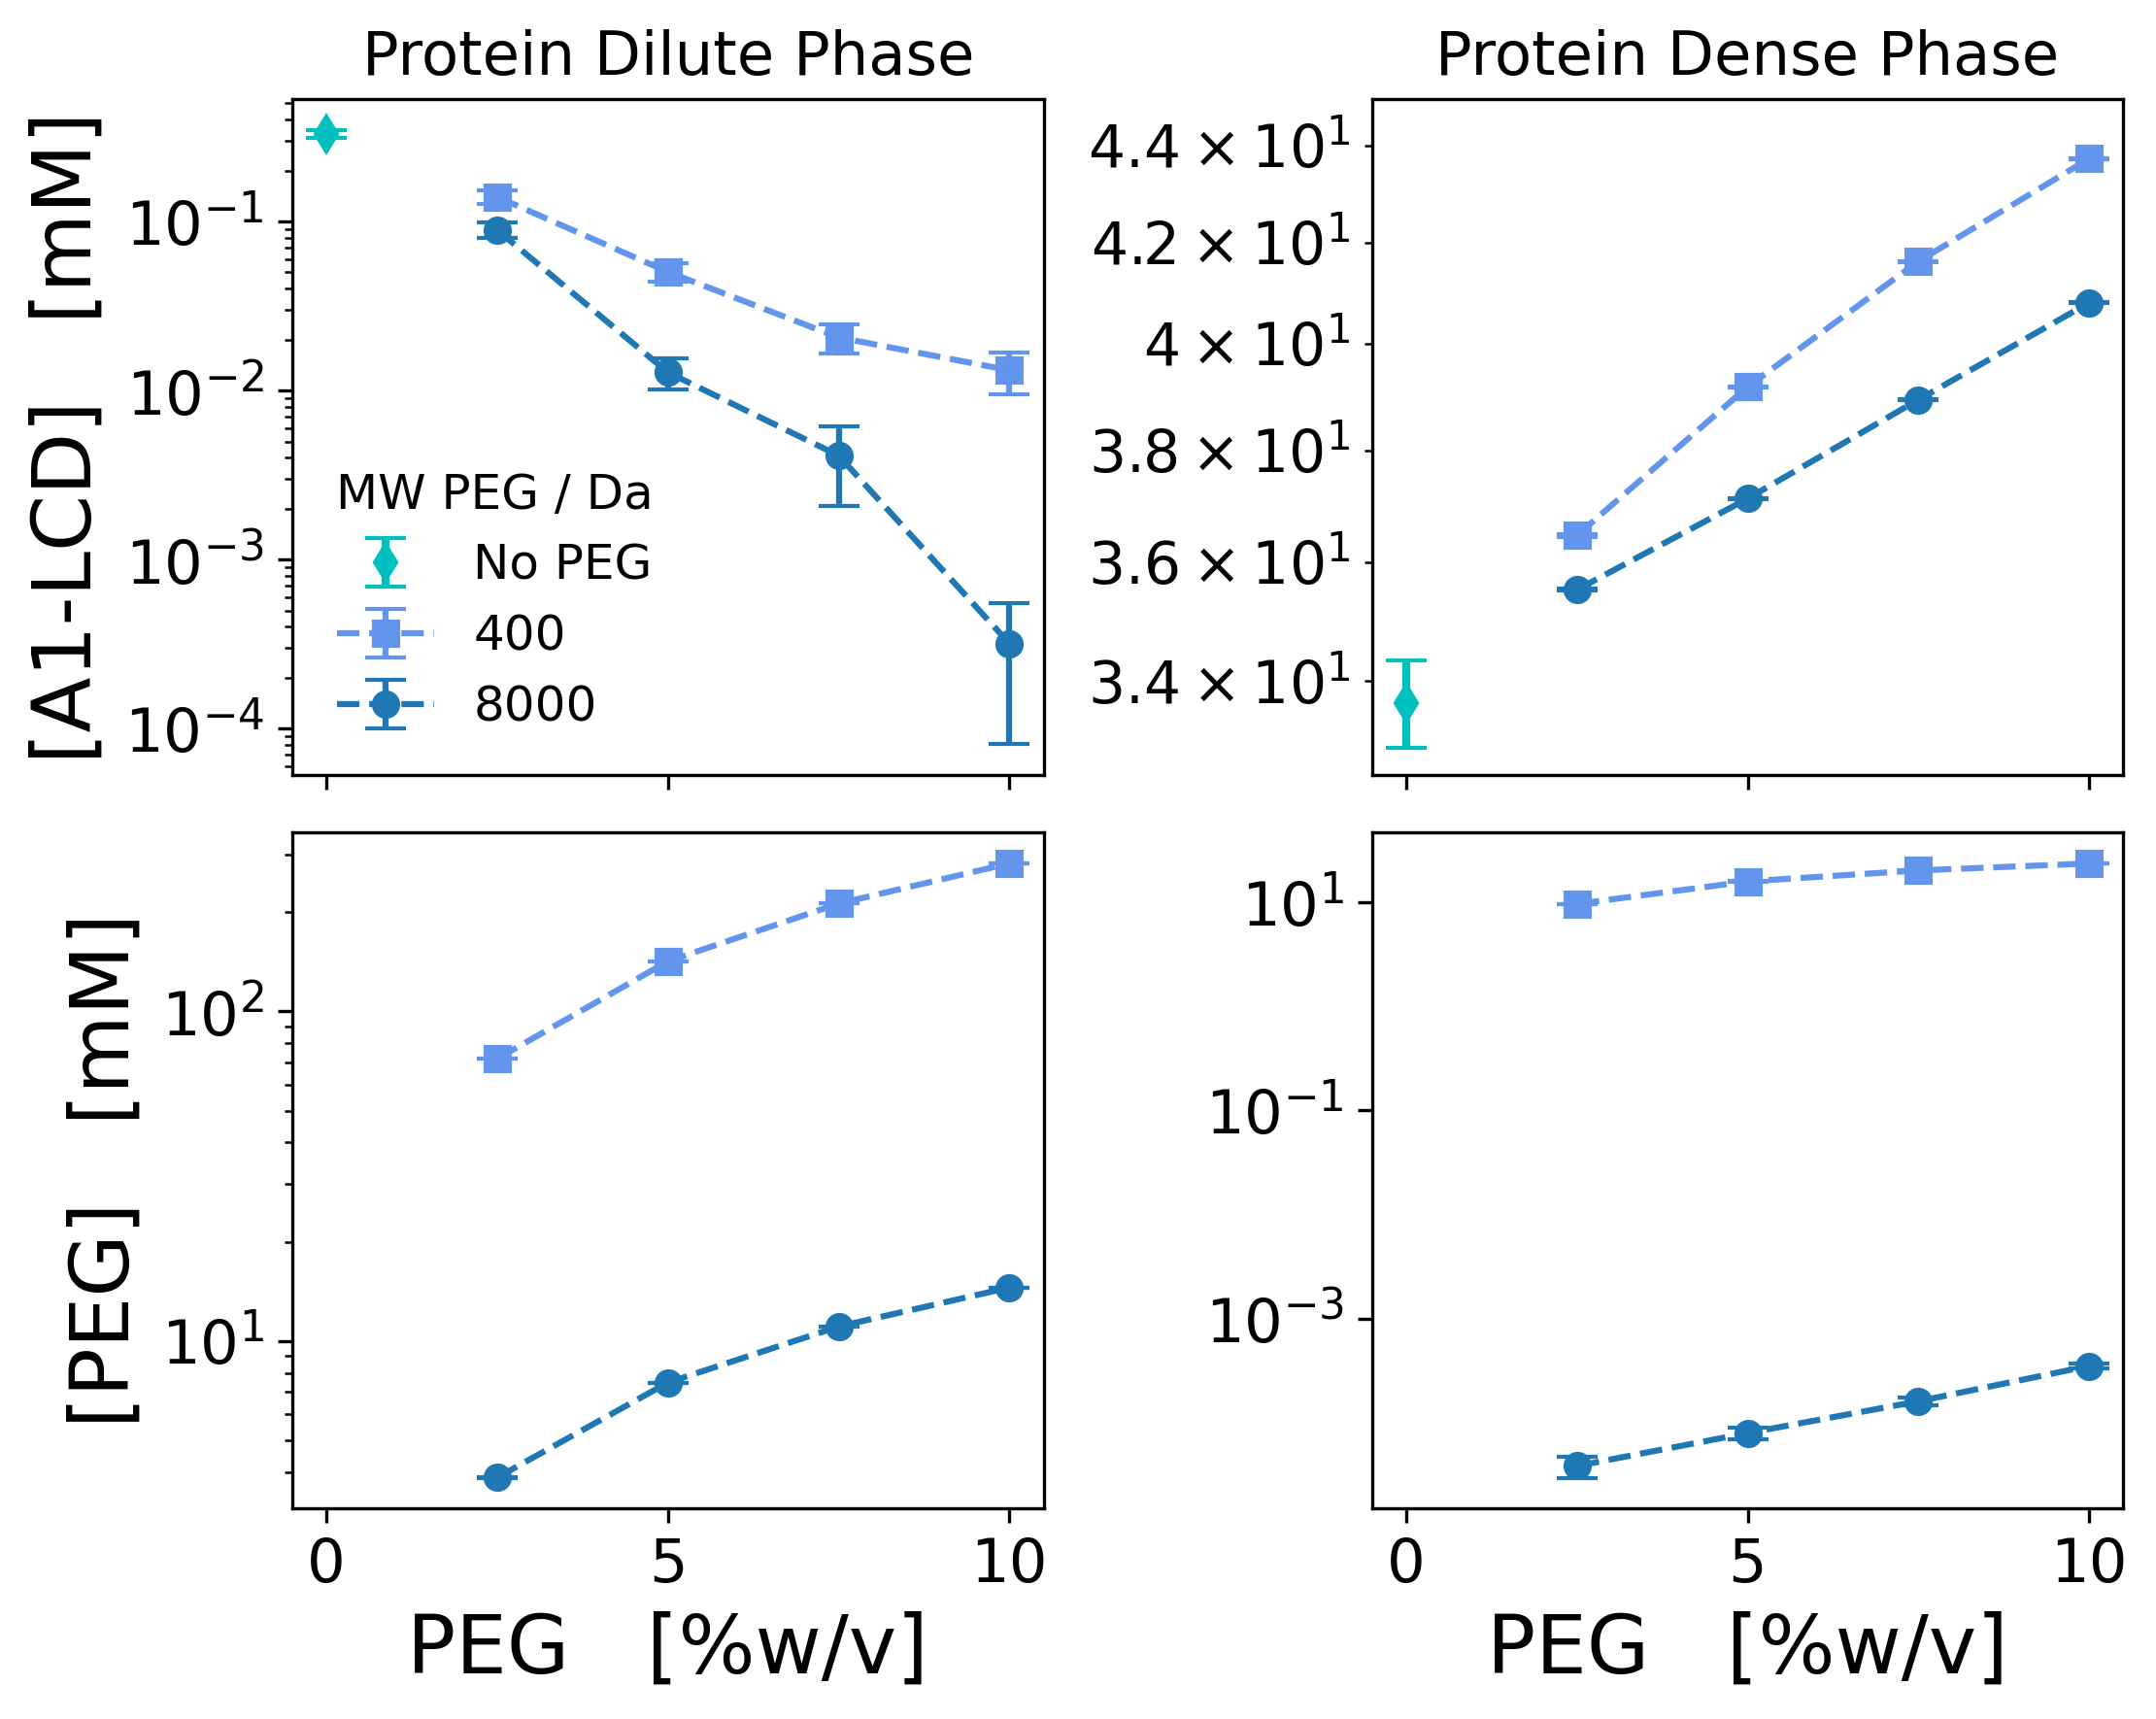

In [ ]:
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(7.5,6),sharex=True,dpi=300)

Cdils_A1 = [ data.loc[('A1', p,0), 'Cdil'] for p in ['PEG400','PEG2000','PEG8000','PEG12000','PEG20000']]
Cdens_A1 = [ data.loc[('A1', p,0), 'Cden'] for p in ['PEG400','PEG2000','PEG8000','PEG12000','PEG20000']]
factor=1

# No PEG
axs[0,0].errorbar(x=[0],
                y=np.mean(Cdils_A1)*factor,
                yerr=np.std(Cdils_A1)*factor,
                marker='d', ls='',lw=2, label=F"No PEG",capsize=5,color='c')#'tab:blue')
axs[0,1].errorbar(x=[0],
                y=np.mean(Cdens_A1)*factor,
                yerr=np.std(Cdens_A1)*factor,
                marker='d', ls='',lw=2,capsize=5,color='c')#'tab:blue')

# PEG400
axs[0,0].errorbar(x=data.loc[('A1','PEG400'),'Cdil'].index[1:],
                  y=data.loc[('A1','PEG400'),'Cdil'].to_numpy()[1:]*factor,
                  yerr=data.loc[('A1','PEG400'),'CdilSEM'].to_numpy()[1:]*factor,
                  c='cornflowerblue',marker='s',barsabove=True,capsize=5,ls='--',label="400")
axs[0,1].errorbar(x=data.loc[('A1','PEG400'),'Cden'].index[1:],
                  y=data.loc[('A1','PEG400'),'Cden'].to_numpy()[1:]*factor,
                  yerr=data.loc[('A1','PEG400'),'CdenSEM'].to_numpy()[1:]*factor,
                  c='cornflowerblue',marker='s',barsabove=True,capsize=5,ls='--')
axs[1,0].errorbar(x=data.loc[('A1','PEG400'),'CdilP'].index.to_numpy()[1:],
                  y=data.loc[('A1','PEG400'),'CdilP'].to_numpy()[1:]*factor,
                  yerr=data.loc[('A1','PEG400'),'CdilPSEM'].to_numpy()[1:]*factor,
                  c='cornflowerblue',marker='s',barsabove=True,capsize=5,ls='--',label="400")
axs[1,1].errorbar(x=data.loc[('A1','PEG400'),'CdenP'].index.to_numpy()[1:],
                  y=data.loc[('A1','PEG400'),'CdenP'].to_numpy()[1:]*factor,
                  yerr=data.loc[('A1','PEG400'),'CdenPSEM'].to_numpy()[1:]*factor,
                  c='cornflowerblue',marker='s',barsabove=True,capsize=5,ls='--')

# PEG8000
axs[0,0].errorbar(x=data.loc[('A1','PEG8000'),'Cdil'].index.to_numpy()[1:-3],
                  y=data.loc[('A1','PEG8000'),'Cdil'].to_numpy()[1:-3]*factor,
                  yerr=data.loc[('A1','PEG8000'),'CdilSEM'].to_numpy()[1:-3]*factor,
                  c='tab:blue',marker='o',barsabove=True,capsize=5,ls='--',label="8000")
axs[0,1].errorbar(x=data.loc[('A1','PEG8000'),'Cden'].index.to_numpy()[1:-3],
                  y=data.loc[('A1','PEG8000'),'Cden'].to_numpy()[1:-3]*factor,
                  yerr=data.loc[('A1','PEG8000'),'CdenSEM'].to_numpy()[1:-3]*factor,
                  c='tab:blue',marker='o',barsabove=True,capsize=5,ls='--')
axs[1,0].errorbar(x=data.loc[('A1','PEG8000'),'CdilP'].index.to_numpy()[1:-3],
                  y=data.loc[('A1','PEG8000'),'CdilP'].to_numpy()[1:-3]*factor,
                  yerr=data.loc[('A1','PEG8000'),'CdilPSEM'].to_numpy()[1:-3]*factor,
                  c='tab:blue',marker='o',barsabove=True,capsize=5,ls='--',label="8000")
axs[1,1].errorbar(x=data.loc[('A1','PEG8000'),'CdenP'].index.to_numpy()[1:-3],
                  y=data.loc[('A1','PEG8000'),'CdenP'].to_numpy()[1:-3]*factor,
                  yerr=data.loc[('A1','PEG8000'),'CdenPSEM'].to_numpy()[1:-3]*factor,
                  c='tab:blue',marker='o',barsabove=True,capsize=5,ls='--')


axs[0,0].set_xlim(-0.5,10.5)
axs[0,0].set_yscale('log')
axs[0,0].set_ylabel("[A1-LCD]   [mM]", fontsize=20)
# axs[0,0].set_xlabel("$\phi_{PEG}$  / %w/v", fontsize=20);
axs[0,0].tick_params(axis='x', labelsize=15)
axs[0,0].tick_params(axis='y', labelsize=15)
axs[0,0].legend(title='MW PEG / Da',title_fontsize=12,fontsize=12,frameon=False)

axs[0,1].set_xlim(-0.5,10.5)
axs[0,1].set_yscale('log')
axs[0,1].set_ylim(32.5,45.)
# axs[1].set_yticks(np.arange(33,47,2))
# axs[1].set_ylabel("[A1]  / mM", fontsize=20)
# axs[0,1].set_xlabel("$\phi_{PEG}$  / %w/v", fontsize=20);
axs[0,1].tick_params(axis='x', labelsize=15)
axs[0,1].tick_params(axis='y', labelsize=15)
axs[0,0].set_title('Protein Dilute Phase', fontsize=15)
axs[0,1].set_title('Protein Dense Phase', fontsize=15)

axs[1,0].set_xlim(-0.5,10.5)
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel("[PEG]   [mM]", fontsize=20)
axs[1,0].set_xlabel("PEG   [%w/v]", fontsize=20);
axs[1,0].tick_params(axis='x', labelsize=15)
axs[1,0].tick_params(axis='y', labelsize=15)
# axs[1,0].legend(title='MW PEG / Da',title_fontsize=12,fontsize=12,frameon=False)

axs[1,1].set_xlim(-0.5,10.5)
axs[1,1].set_yscale('log')
# axs[1,1].set_ylim(32.5,45)
# axs[1].set_yticks(np.arange(33,47,2))
# axs[1].set_ylabel("[A1]  / mM", fontsize=20)
axs[1,1].set_xlabel("PEG   [%w/v]", fontsize=20);
axs[1,1].tick_params(axis='x', labelsize=15)
axs[1,1].tick_params(axis='y', labelsize=15)
# axs[1,0].set_title('$C_{sat.}$', fontsize=15)
# axs[1,1].set_title('$C_{con.}$', fontsize=15)
# axs[1].legend(title='MW PEG / Da',title_fontsize=15,fontsize=15)
fig.tight_layout();
# fig.savefig("./figures/sup-figure__A1-PEGs__Prot-PEG-concentrations-vs-PEG__13022025.pdf");
fig.savefig("./figures/figure-S3__A1-PEGs__Prot-PEG-concentrations-vs-PEG.pdf");

### Figure S4

/tmp/ipykernel_711317/879699116.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  axs[0,0].errorbar(x=data.loc[('AroMM','PEG8000'),'Cdil'].index.to_numpy()[1:],
/tmp/ipykernel_711317/879699116.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  y=data.loc[('AroMM','PEG8000'),'Cdil'].to_numpy()[1:],
/tmp/ipykernel_711317/879699116.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  yerr=data.loc[('AroMM','PEG8000'),'CdilSEM'].to_numpy()[1:],
/tmp/ipykernel_711317/879699116.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  axs[0,1].errorbar(x=data.loc[('AroMM','PEG8000'),'Cden'].index.to_numpy()[1:],
/tmp/ipykernel_711317/879699116.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  y=data.loc[('AroMM','PEG8000'),'Cden'].to_numpy()[1:],
/tmp/ipykernel_711317/879699116.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
 

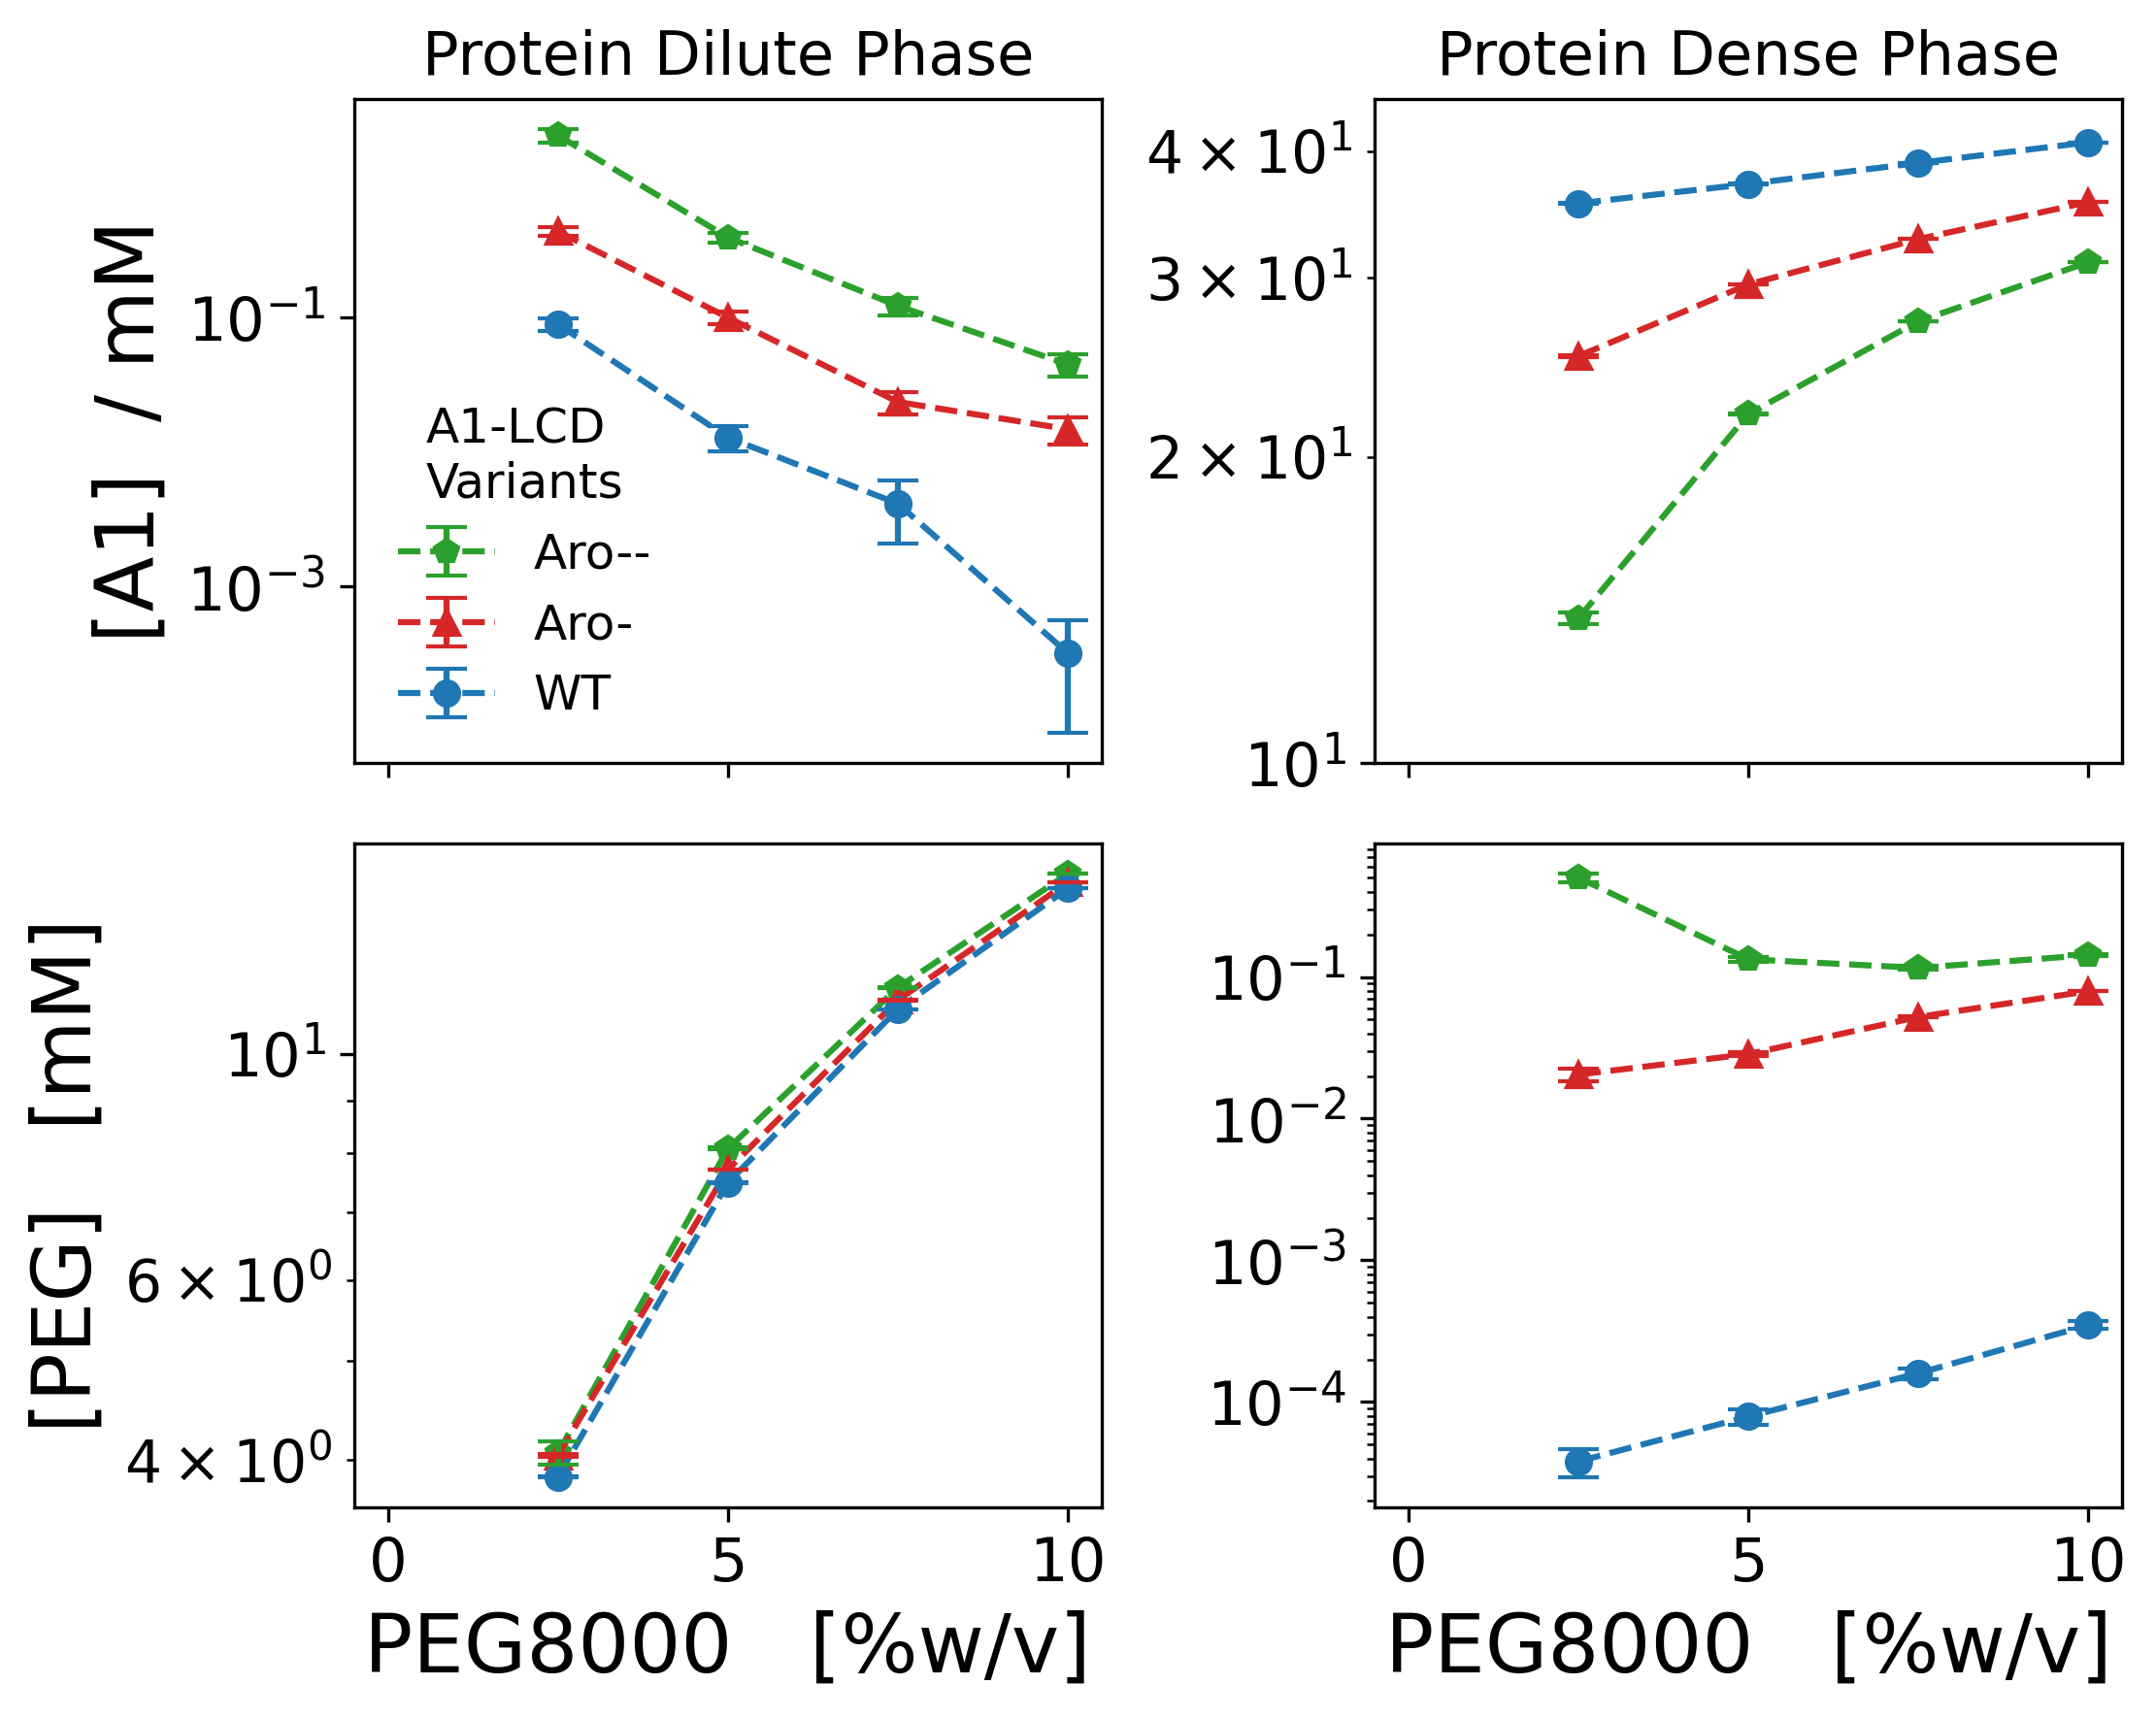

In [ ]:
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(7.5,6),sharex=True,dpi=300)
# PEG8000 - Aro--
axs[0,0].errorbar(x=data.loc[('AroMM','PEG8000'),'Cdil'].index.to_numpy()[1:],
                  y=data.loc[('AroMM','PEG8000'),'Cdil'].to_numpy()[1:],
                  yerr=data.loc[('AroMM','PEG8000'),'CdilSEM'].to_numpy()[1:],
                  c='tab:green',marker='p',barsabove=True,capsize=5,ls='--',label="Aro--")
axs[0,1].errorbar(x=data.loc[('AroMM','PEG8000'),'Cden'].index.to_numpy()[1:],
                  y=data.loc[('AroMM','PEG8000'),'Cden'].to_numpy()[1:],
                  yerr=data.loc[('AroMM','PEG8000'),'CdenSEM'].to_numpy()[1:],
                  c='tab:green',marker='p',barsabove=True,capsize=5,ls='--')
axs[1,0].errorbar(x=data.loc[('AroMM','PEG8000'),'CdilP'].index.to_numpy()[1:],
                  y=data.loc[('AroMM','PEG8000'),'CdilP'].to_numpy()[1:],
                  yerr=data.loc[('AroMM','PEG8000'),'CdilPSEM'].to_numpy()[1:],
                  c='tab:green',marker='p',barsabove=True,capsize=5,ls='--')
axs[1,1].errorbar(x=data.loc[('AroMM','PEG8000'),'CdenP'].index.to_numpy()[1:],
                  y=data.loc[('AroMM','PEG8000'),'CdenP'].to_numpy()[1:],
                  yerr=data.loc[('AroMM','PEG8000'),'CdenPSEM'].to_numpy()[1:],
                  c='tab:green',marker='p',barsabove=True,capsize=5,ls='--')
# PEG8000 - Aro-
axs[0,0].errorbar(x=data.loc[('AroM','PEG8000'),'Cdil'].index.to_numpy()[1:],
                  y=data.loc[('AroM','PEG8000'),'Cdil'].to_numpy()[1:],
                  yerr=data.loc[('AroM','PEG8000'),'CdilSEM'].to_numpy()[1:],
                  c='tab:red',marker='^',barsabove=True,capsize=5,ls='--',label="Aro-")
axs[0,1].errorbar(x=data.loc[('AroM','PEG8000'),'Cden'].index.to_numpy()[1:],
                  y=data.loc[('AroM','PEG8000'),'Cden'].to_numpy()[1:],
                  yerr=data.loc[('AroM','PEG8000'),'CdenSEM'].to_numpy()[1:],
                  c='tab:red',marker='^',barsabove=True,capsize=5,ls='--')
axs[1,0].errorbar(x=data.loc[('AroM','PEG8000'),'CdilP'].index.to_numpy()[1:],
                  y=data.loc[('AroM','PEG8000'),'CdilP'].to_numpy()[1:],
                  yerr=data.loc[('AroM','PEG8000'),'CdilPSEM'].to_numpy()[1:],
                  c='tab:red',marker='^',barsabove=True,capsize=5,ls='--')
axs[1,1].errorbar(x=data.loc[('AroM','PEG8000'),'CdenP'].index.to_numpy()[1:],
                  y=data.loc[('AroM','PEG8000'),'CdenP'].to_numpy()[1:],
                  yerr=data.loc[('AroM','PEG8000'),'CdenPSEM'].to_numpy()[1:],
                  c='tab:red',marker='^',barsabove=True,capsize=5,ls='--')

# PEG8000
axs[0,0].errorbar(x=data.loc[('A1','PEG8000'),'Cdil'].index.to_numpy()[1:-3],
                  y=data.loc[('A1','PEG8000'),'Cdil'].to_numpy()[1:-3],
                  yerr=data.loc[('A1','PEG8000'),'CdilSEM'].to_numpy()[1:-3],
                  c='tab:blue',marker='o',barsabove=True,capsize=5,ls='--',label="WT")
axs[0,1].errorbar(x=data.loc[('A1','PEG8000'),'Cden'].index.to_numpy()[1:-3],
                  y=data.loc[('A1','PEG8000'),'Cden'].to_numpy()[1:-3],
                  yerr=data.loc[('A1','PEG8000'),'CdenSEM'].to_numpy()[1:-3],
                  c='tab:blue',marker='o',barsabove=True,capsize=5,ls='--')
axs[1,0].errorbar(x=data.loc[('A1','PEG8000'),'CdilP'].index.to_numpy()[1:-3],
                  y=data.loc[('A1','PEG8000'),'CdilP'].to_numpy()[1:-3],
                  yerr=data.loc[('A1','PEG8000'),'CdilPSEM'].to_numpy()[1:-3],
                  c='tab:blue',marker='o',barsabove=True,capsize=5,ls='--')
axs[1,1].errorbar(x=data.loc[('A1','PEG8000'),'CdenP'].index.to_numpy()[1:-3],
                  y=data.loc[('A1','PEG8000'),'CdenP'].to_numpy()[1:-3],
                  yerr=data.loc[('A1','PEG8000'),'CdenPSEM'].to_numpy()[1:-3],
                  c='tab:blue',marker='o',barsabove=True,capsize=5,ls='--')


axs[0,0].set_xlim(-0.5,10.5)
axs[0,0].set_yscale('log')
axs[0,0].set_ylabel("[A1]  / mM", fontsize=20)
axs[0,0].tick_params(axis='x', labelsize=15)
axs[0,0].tick_params(axis='y', labelsize=15)
axs[0,0].legend(title='A1-LCD\nVariants',title_fontsize=12,fontsize=12,frameon=False)

axs[0,1].set_xlim(-0.5,10.5)
axs[0,1].set_yscale('log')
axs[0,1].set_ylim(10,45)
axs[0,1].tick_params(axis='x', labelsize=15)
axs[0,1].tick_params(axis='y', labelsize=15)
axs[0,0].set_title('Protein Dilute Phase', fontsize=15)
axs[0,1].set_title('Protein Dense Phase', fontsize=15)

axs[1,0].set_xlim(-0.5,10.5)
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel("[PEG]   [mM]", fontsize=20)
axs[1,0].set_xlabel("PEG8000   [%w/v]", fontsize=20);
axs[1,0].tick_params(axis='x', labelsize=15)
axs[1,0].tick_params(axis='y', labelsize=15)

axs[1,1].set_xlim(-0.5,10.5)
axs[1,1].set_yscale('log')

axs[1,1].set_xlabel("PEG8000   [%w/v]", fontsize=20);
axs[1,1].tick_params(axis='x', labelsize=15)
axs[1,1].tick_params(axis='y', labelsize=15)
fig.tight_layout();
fig.savefig("./figures/figure-S4__A1-Variants__Prot-PEG-concentrations-vs-PEG.pdf");

### Figure S5

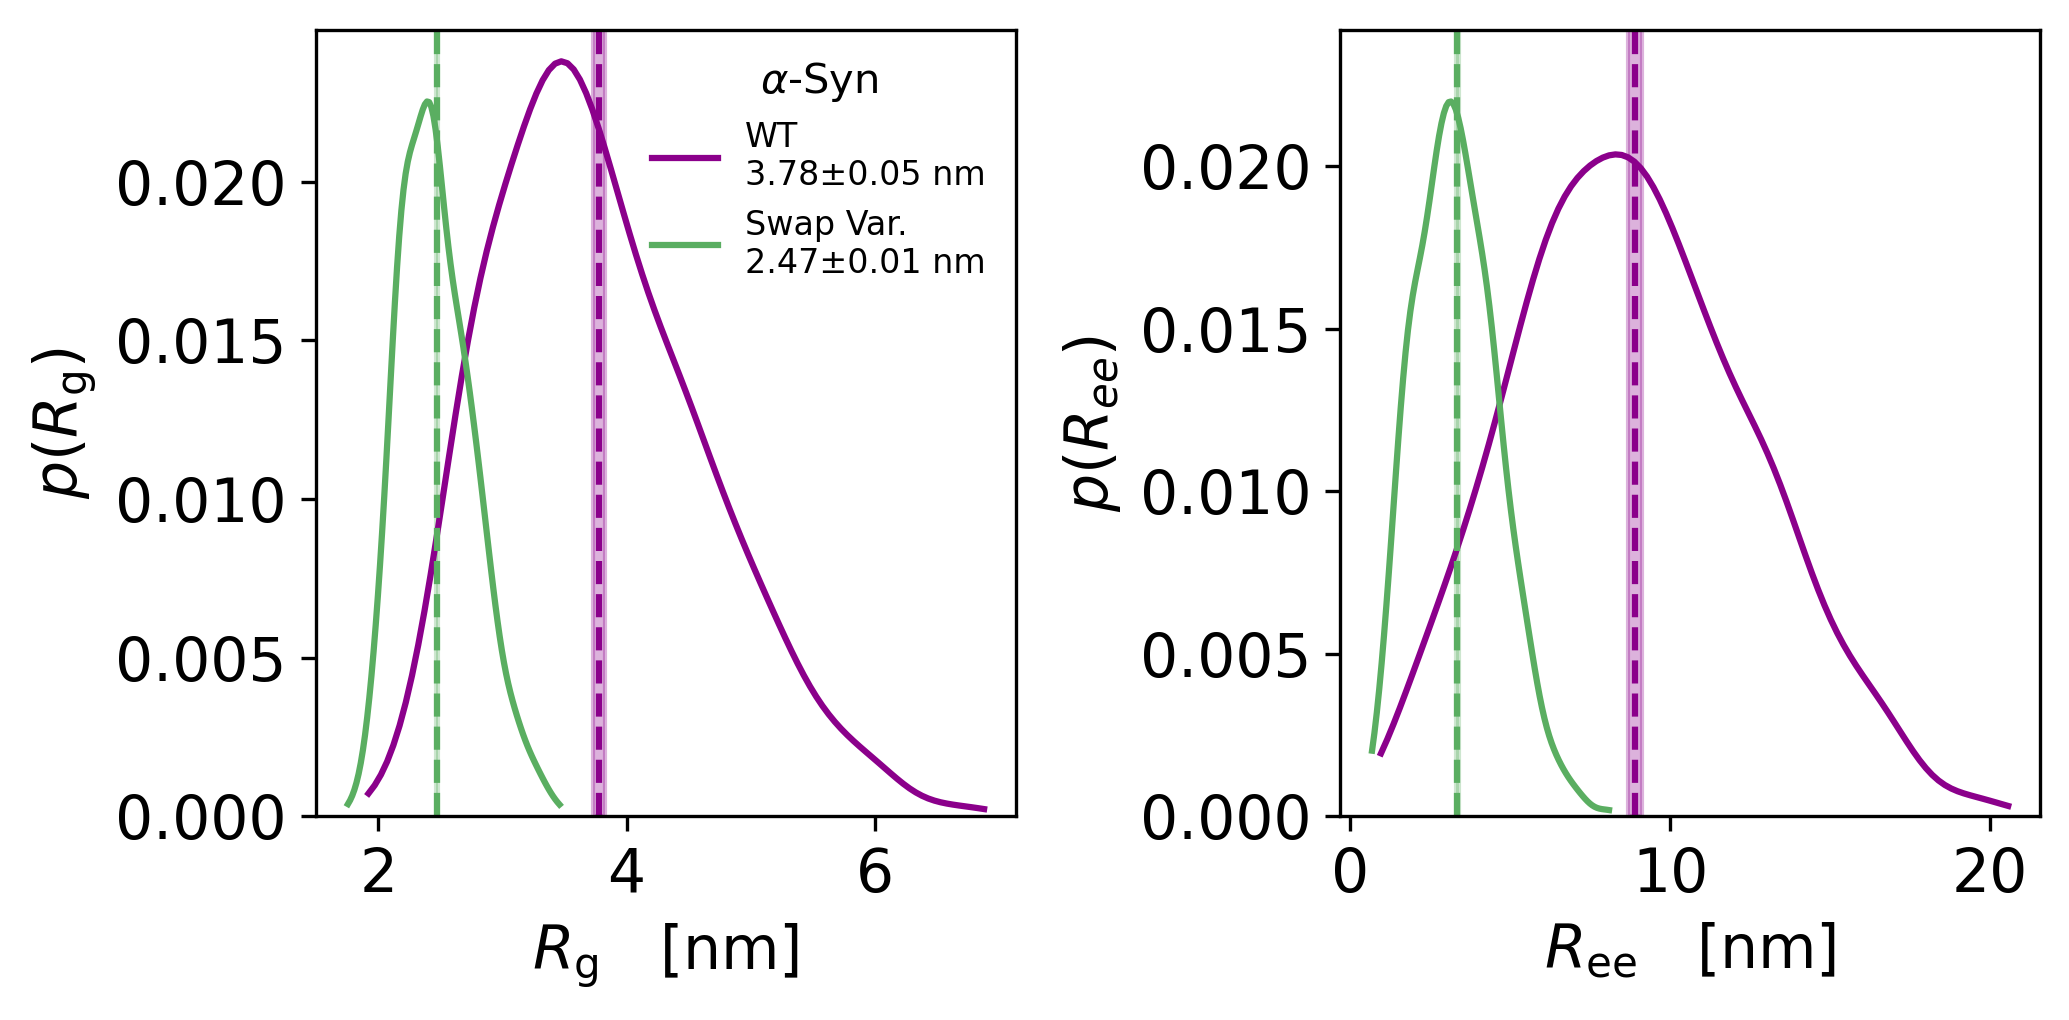

In [28]:
import scipy.stats as scs
def autoblock(cv, multi=1, plot=False):
    block = BlockAnalysis(cv, multi=multi)
    block.SEM()
    if plot == True:
        plt.errorbar(block.stat[...,0], block.stat[...,1], block.stat[...,2], fmt='', color='k', ecolor='0.5')
        plt.scatter(block.bs, block.sem,zorder=10,c='tab:red')
        plt.xlabel('Block size')
        plt.ylabel('SEM')
        plt.show()
    return block.av, block.sem, block.bs


def kde(a):
    min_ = np.min(a)
    max_ = np.max(a)
    x = np.linspace( min_, max_, num = 100 )
    d = scs.gaussian_kde( a, bw_method = "silverman" ).evaluate(x)
    u = np.average(a)

    return x,d/np.sum(d),u

# Load simulation data
sc_aSyn_wt  = pd.read_csv("./single-chain__aSyn-both/aSyn_wt_IDRLab/time_series_Rg_Ree_Delta_S.csv",index_col=0)
sc_aSyn_var = pd.read_csv("./single-chain__aSyn-both/aSyn_compact_IDRLab/time_series_Rg_Ree_Delta_S.csv",index_col=0)


# Plot results
mpl.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(1,2, figsize=(7,3.5), facecolor='w', dpi=300, layout='tight')
axs = axs.flatten()

for rg_array,ree_array,col,lab in zip([sc_aSyn_wt['Rg (nm)'],sc_aSyn_var['Rg (nm)']],
                                      [sc_aSyn_wt['Ree (nm)'],sc_aSyn_var['Ree (nm)']],
                                      ['darkmagenta','#5aae61'],
                                      ['WT','Swap Var.']):
    rg, rg_err, _ = autoblock(rg_array)
    rg_hist = kde(rg_array)
    ree, ree_err, _ = autoblock(ree_array)
    ree_hist = kde(ree_array)
    axs[0].plot(rg_hist[0],rg_hist[1],label=F"{lab}\n{rg:.2f}±{rg_err:.2f} nm",color=col)
    top = rg_hist[1].max()+0.1*rg_hist[1].max()
    axs[0].vlines(rg,0,top,color=col,ls='--')
    axs[0].set_xlabel(r'$R_\mathrm{g}$   [nm]')
    axs[0].set_ylabel(r'$p(R_\mathrm{g})$')
    axs[0].set_ylim(0,top)
    axs[0].fill_between([rg-rg_err,rg+rg_err],0,top,alpha=0.3,color=col)

    axs[1].plot(ree_hist[0],ree_hist[1],color=col)
    top = ree_hist[1].max()+0.1*ree_hist[1].max()
    axs[1].vlines(ree,0,top+0.3,color=col,ls='--')
    axs[1].set_xlabel(r'$R_\mathrm{ee}$   [nm]')
    axs[1].set_ylabel(r'$p(R_{ee})$')
    axs[1].set_ylim(0,top)
    axs[1].fill_between([ree-ree_err,ree+ree_err],0,top+0.3,alpha=0.3,color=col)

    
axs[0].legend(title=r'$\alpha$-Syn',title_fontsize=10,fontsize=8,frameon=False,loc='upper right')
fig.savefig('./figures/figure-S5__rg-ree_distributions__aSyn-variants.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait',
            bbox_inches='tight')

### Figure S6

/tmp/ipykernel_711317/2241057535.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  axs[0,0].errorbar(x=data.loc[('aSyn','PEG8000'),'Cdil'].index.to_numpy()[4:],
/tmp/ipykernel_711317/2241057535.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  y=data.loc[('aSyn','PEG8000'),'Cdil'].to_numpy()[4:],
/tmp/ipykernel_711317/2241057535.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  yerr=data.loc[('aSyn','PEG8000'),'CdilSEM'].to_numpy()[4:],
/tmp/ipykernel_711317/2241057535.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  axs[0,1].errorbar(x=data.loc[('aSyn','PEG8000'),'Cden'].index.to_numpy()[4:],
/tmp/ipykernel_711317/2241057535.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  y=data.loc[('aSyn','PEG8000'),'Cden'].to_numpy()[4:],
/tmp/ipykernel_711317/2241057535.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.


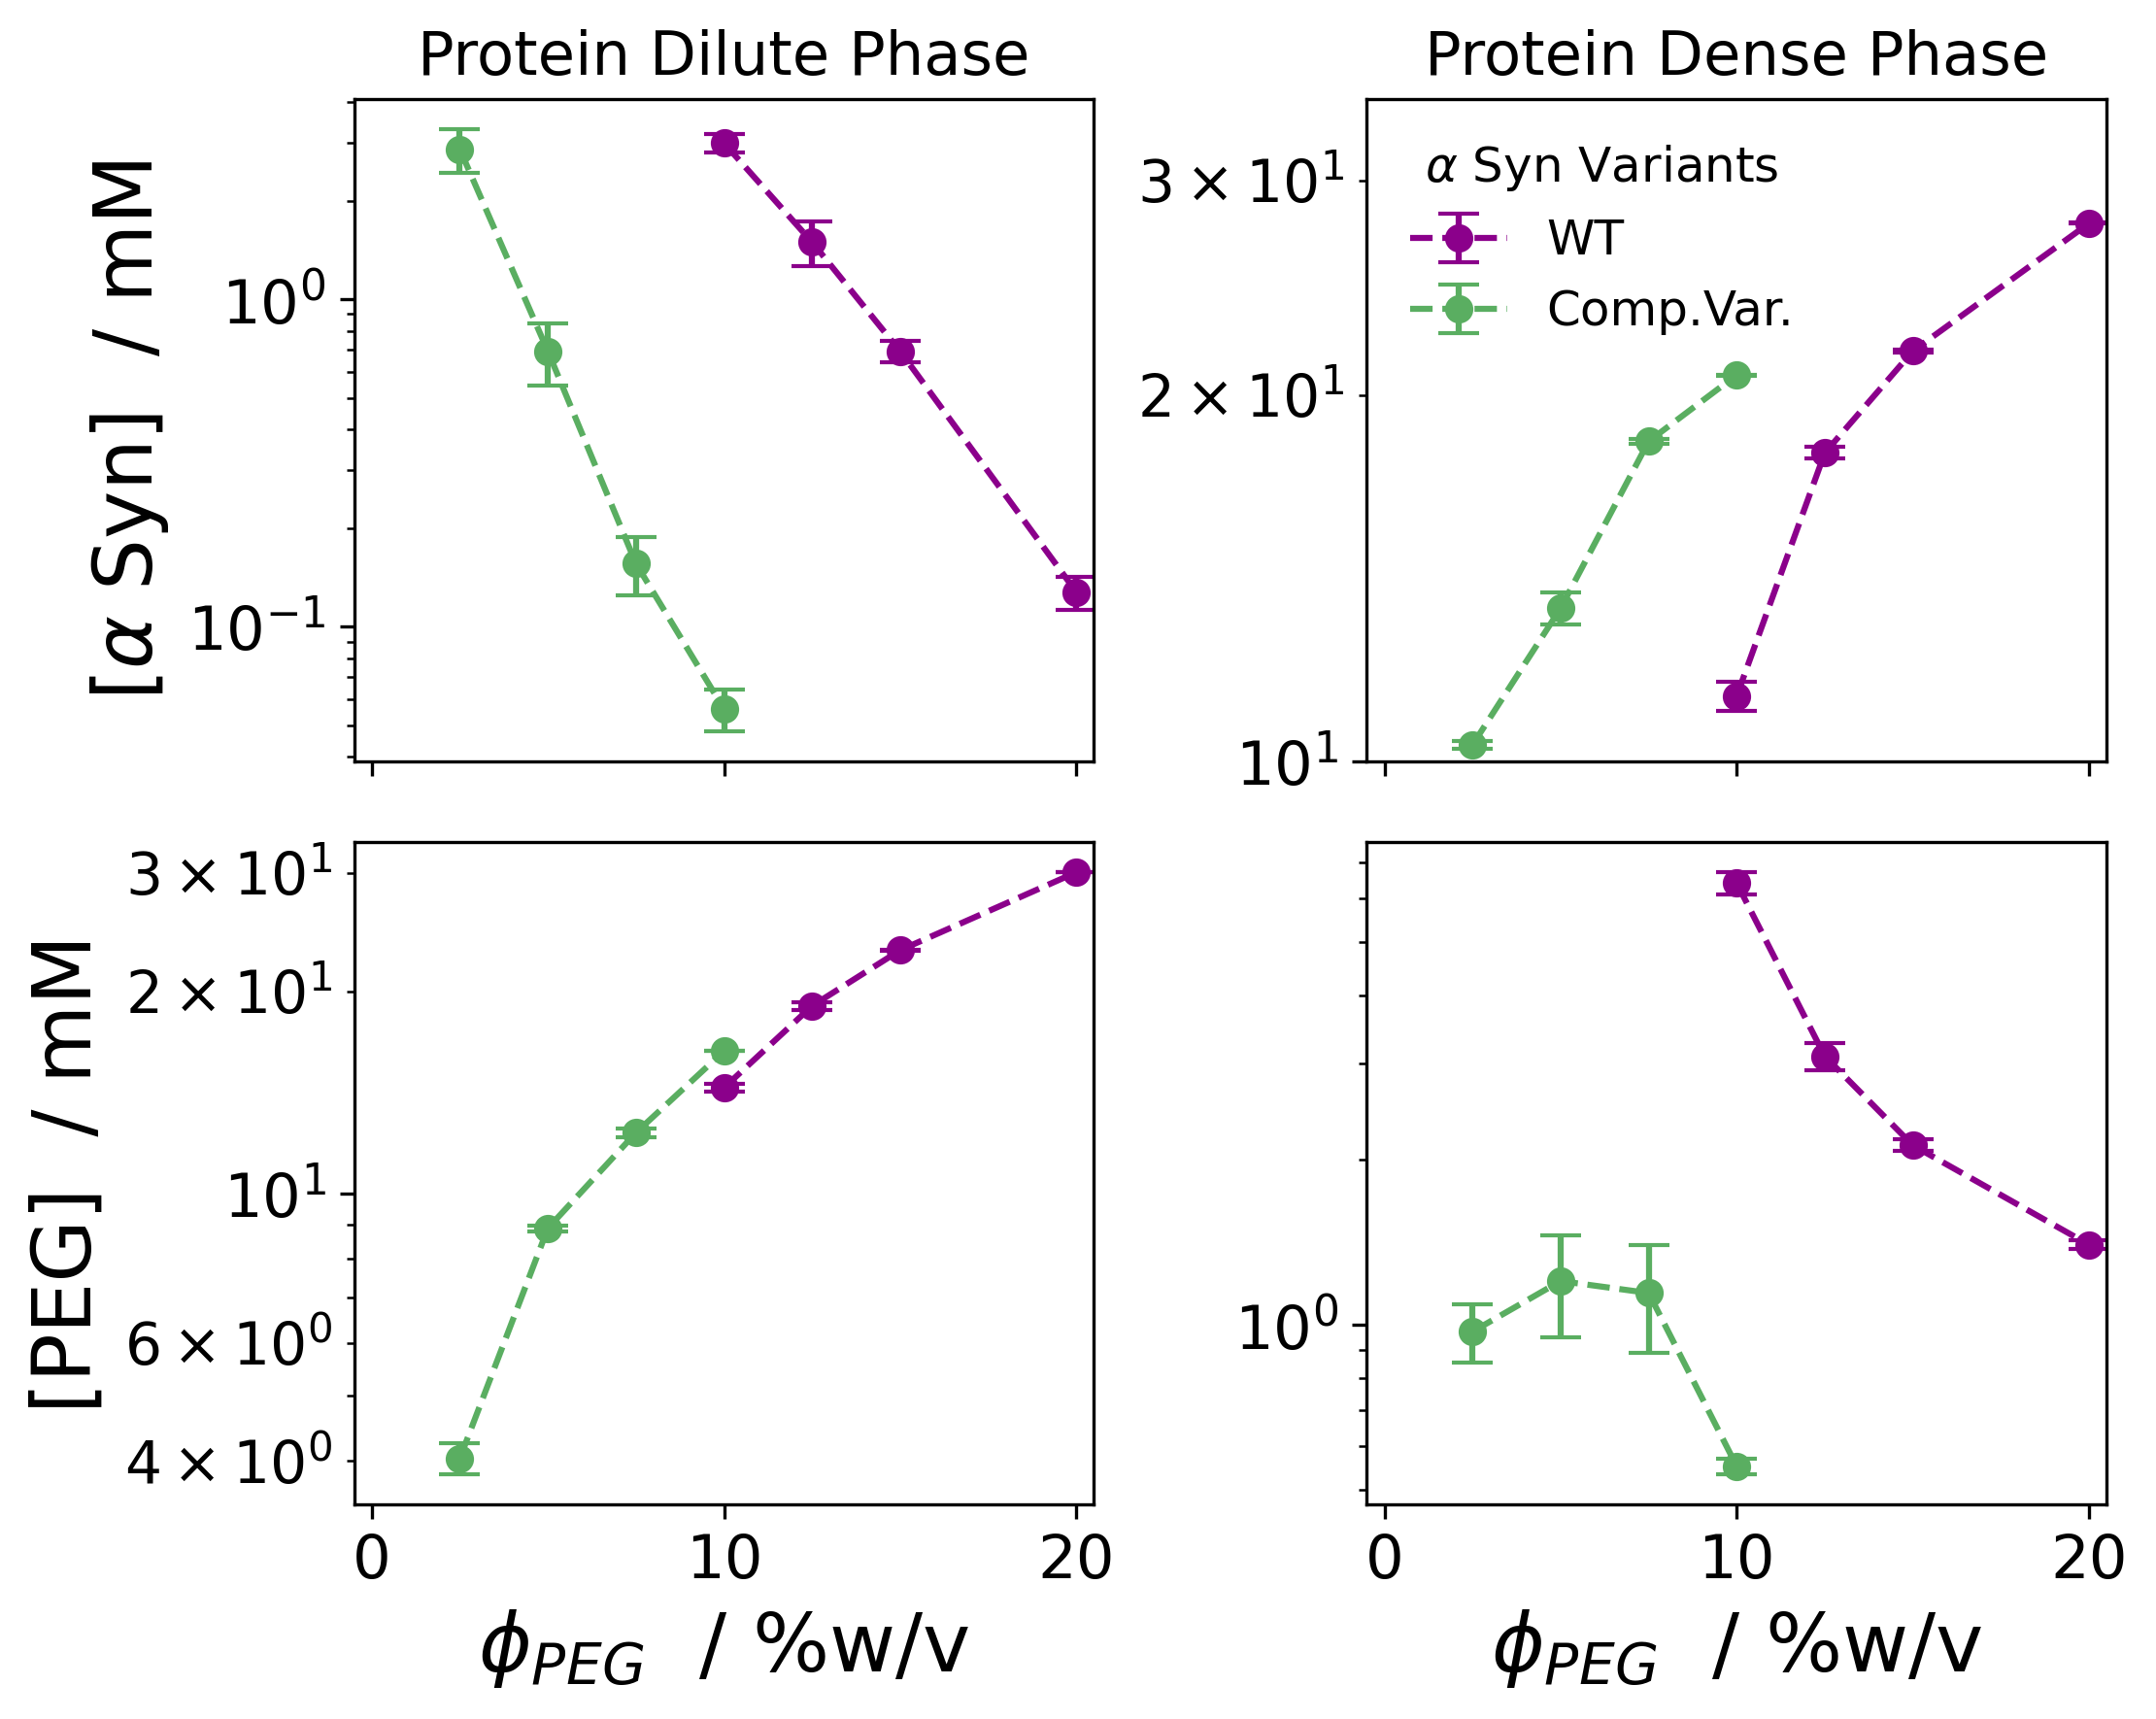

In [ ]:
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(7.5,6),sharex=True,dpi=300)
# PEG8000 - aSyn WT
axs[0,0].errorbar(x=data.loc[('aSyn','PEG8000'),'Cdil'].index.to_numpy()[4:],
                  y=data.loc[('aSyn','PEG8000'),'Cdil'].to_numpy()[4:],
                  yerr=data.loc[('aSyn','PEG8000'),'CdilSEM'].to_numpy()[4:],
                  c='darkmagenta',marker='o',barsabove=True,capsize=5,ls='--',label="WT")
axs[0,1].errorbar(x=data.loc[('aSyn','PEG8000'),'Cden'].index.to_numpy()[4:],
                  y=data.loc[('aSyn','PEG8000'),'Cden'].to_numpy()[4:],
                  yerr=data.loc[('aSyn','PEG8000'),'CdenSEM'].to_numpy()[4:],
                  c='darkmagenta',marker='o',barsabove=True,capsize=5,ls='--',label="WT")
axs[1,0].errorbar(x=data.loc[('aSyn','PEG8000'),'CdilP'].index.to_numpy()[4:],
                  y=data.loc[('aSyn','PEG8000'),'CdilP'].to_numpy()[4:],
                  yerr=data.loc[('aSyn','PEG8000'),'CdilPSEM'].to_numpy()[4:],
                  c='darkmagenta',marker='o',barsabove=True,capsize=5,ls='--')
axs[1,1].errorbar(x=data.loc[('aSyn','PEG8000'),'CdenP'].index.to_numpy()[4:],
                  y=data.loc[('aSyn','PEG8000'),'CdenP'].to_numpy()[4:],
                  yerr=data.loc[('aSyn','PEG8000'),'CdenPSEM'].to_numpy()[4:],
                  c='darkmagenta',marker='o',barsabove=True,capsize=5,ls='--')

# PEG8000 - aSyn Comp.Var.
axs[0,0].errorbar(x=data_var.loc[('aSyn2745','PEG8000'),'Cdil'].index.to_numpy()[1:],
                  y=data_var.loc[('aSyn2745','PEG8000'),'Cdil'].to_numpy()[1:],
                  yerr=data_var.loc[('aSyn2745','PEG8000'),'CdilSEM'].to_numpy()[1:],
                  c='#5aae61',marker='o',barsabove=True,capsize=5,ls='--',label="Comp.Var.")
axs[0,1].errorbar(x=data_var.loc[('aSyn2745','PEG8000'),'Cden'].index.to_numpy()[1:],
                  y=data_var.loc[('aSyn2745','PEG8000'),'Cden'].to_numpy()[1:],
                  yerr=data_var.loc[('aSyn2745','PEG8000'),'CdenSEM'].to_numpy()[1:],
                  c='#5aae61',marker='o',barsabove=True,capsize=5,ls='--',label="Comp.Var.")
axs[1,0].errorbar(x=data_var.loc[('aSyn2745','PEG8000'),'CdilP'].index.to_numpy()[1:],
                  y=data_var.loc[('aSyn2745','PEG8000'),'CdilP'].to_numpy()[1:],
                  yerr=data_var.loc[('aSyn2745','PEG8000'),'CdilPSEM'].to_numpy()[1:],
                  c='#5aae61',marker='o',barsabove=True,capsize=5,ls='--')
axs[1,1].errorbar(x=data_var.loc[('aSyn2745','PEG8000'),'CdenP'].index.to_numpy()[1:],
                  y=data_var.loc[('aSyn2745','PEG8000'),'CdenP'].to_numpy()[1:],
                  yerr=data_var.loc[('aSyn2745','PEG8000'),'CdenPSEM'].to_numpy()[1:],
                  c='#5aae61',marker='o',barsabove=True,capsize=5,ls='--')


axs[0,0].set_xlim(-0.5,20.5)
axs[0,0].set_yscale('log')
axs[0,0].set_ylabel(r"[$\alpha$ Syn]  / mM", fontsize=20)
axs[0,0].tick_params(axis='x', labelsize=15)z
axs[0,0].tick_params(axis='y', labelsize=15)
axs[0,1].legend(title=r'$\alpha$ Syn Variants',title_fontsize=12,fontsize=12,frameon=False,loc='upper left')

axs[0,1].set_xlim(-0.5,20.5)
axs[0,1].set_yscale('log')
axs[0,1].set_ylim(10,35)
axs[0,1].tick_params(axis='y', labelsize=15)
axs[0,0].set_title('Protein Dilute Phase', fontsize=15)
axs[0,1].set_title('Protein Dense Phase', fontsize=15)

axs[1,0].set_xlim(-0.5,20.5)
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel("[PEG]  / mM", fontsize=20)
axs[1,0].set_xlabel("$\phi_{PEG}$  / %w/v", fontsize=20);
axs[1,0].tick_params(axis='x', labelsize=15)
axs[1,0].tick_params(axis='y', labelsize=15)

axs[1,1].set_xlim(-0.5,20.5)
axs[1,1].set_yscale('log')
axs[1,1].set_xlabel("$\phi_{PEG}$  / %w/v", fontsize=20);
axs[1,1].tick_params(axis='x', labelsize=15)
axs[1,1].tick_params(axis='y', labelsize=15)
fig.tight_layout();
fig.savefig("./figures/figure-S6__aSyn-variants__Prot-PEG-concentrations-vs-PEG.pdf");